Output from Splotch is a set of DE genes per region. Compare this set of genes with ABA DE genes

### runs on stenv3

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
import operator
import matplotlib
import scipy.stats as stats
import statsmodels.stats.multitest as multi
from collections import defaultdict
from ast import literal_eval
import scanpy as sc
from matplotlib.patches import Patch
from matplotlib import cm
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 6
pd.set_option("display.max_rows", 50, "display.max_columns", 50)
sns.set_style("ticks")
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, frameon=True, vector_friendly=True, fontsize=20, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')

In /Users/sanjavickovic/miniconda2/envs/stenv3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/sanjavickovic/miniconda2/envs/stenv3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/sanjavickovic/miniconda2/envs/stenv3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/sanjavickovic/miniconda2/envs/stenv3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

Load definitions

In [2]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

def union(lst1, lst2): 
    final_list = lst1 + lst2 
    return final_list

def ftest(aba_spec_cutoff,st_spec_cutoff):
    # DIFFERENTIAL GENES PER REGION - Fisher's exact test
    bb_count = 0
    fisher_dict = {}
    pval_list = []

    ct = np.unique(aba_spec_cutoff['ident'].tolist())
    for condition, df in st_spec_cutoff.groupby('condition_1'):

            ####################### Fisher's exact test
            #########################################################################
            #regions_tmp = list(set(st_spec_cutoff['ABA_aar1'].tolist()))
            print(condition)
            regions_tmp = list(set(st_spec_cutoff['AAR1'].tolist()))

            regions = [x for x in regions_tmp if str(x) != 'nan']

            for i in regions:

                for j in ct:
                    # print(i,j)
                    #break

                    #ST genes
                    #st_genes = df[df['ABA_aar1'] == i]['gene'].tolist()
                    st_genes = df[df['AAR1'] == i]['gene_new'].tolist()

                    # ABA-genes
                    aba_genes = aba_spec_cutoff[aba_spec_cutoff['ident'] == j]['gene'].tolist()

                    # ST genes in all other regions
                    #st_rest = df[df['ABA_aar1'] != i]['gene'].tolist()
                    st_rest = df[df['AAR1'] != i]['gene_new'].tolist()

                    # ABA genes in all other regions
                    aba_rest = aba_spec_cutoff[aba_spec_cutoff['ident'] != j]['gene'].tolist()

                    # g1 = genes in both ST and ABA
                    # g2 = genes unique to ST
                    # g3 = genes unique to ABA
                    # g4 = genes neither in st or aba region but in the other regions

                    g1 = len(list(set(st_genes).intersection(aba_genes)))
                    g2 = len(list(set(aba_genes).difference(set(st_genes)))) 
                    g3 = len(list(set(st_genes).difference(set(aba_genes))))
                    g4 = len(list(set(st_rest).intersection(aba_rest)))

                    # print(list(set(st_genes).intersection(aba_genes)))

                    # Fisher's test
                    oddsratio, pvalue = stats.fisher_exact([[g4, g2], [g3, g1]], alternative='greater')

                    # Store pvalues in list to use for multiple corrections testing
                    pval_list.append(pvalue)

                    # Store fisher's test results in DF
                    ff = [condition, i, j, oddsratio, pvalue, g1,list(set(st_genes).intersection(aba_genes)) ]
                    # print(i, j, g1, g2, g3, g4, pvalue)

                    if bb_count == 0:
                        fisher_dict[bb_count] = ff

                        df_ff = pd.DataFrame.from_dict(fisher_dict)

                        df_ff['idx'] = ['condition', 'AAR_ST', 'ident','Odds ratio', 'p value', 'Num shared genes', 'shared genes']

                        df_ff.set_index('idx', inplace = True)

                        bb_count += 1
                    else:
                        df_ff[bb_count] = ff

                        bb_count += 1

    # Do multiple testing correction on the pvalues
    pp = multi.multipletests(pval_list, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

    df_ff_t = df_ff.T 

    # Add corrected p-values
    df_ff_t['p-value, corrected'] = list(pp[1])
    
    return df_ff_t

def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=grouped.groups.keys(),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

def cluster_color_map(cc):
    # create color map
    cmap1 = cm.get_cmap('tab20b')
    c1 = [matplotlib.colors.rgb2hex(cmap1(i)) for i in range(cmap1.N)]
    cmap2 = cm.get_cmap('tab20c')
    c2 = [matplotlib.colors.rgb2hex(cmap2(i)) for i in range(cmap2.N)]
    cmap3 = cm.get_cmap('Accent')
    c3 = [matplotlib.colors.rgb2hex(cmap3(i)) for i in range(cmap3.N)]
    cmap4 = cm.get_cmap('Set2')
    c4 = [matplotlib.colors.rgb2hex(cmap4(i)) for i in range(cmap4.N)]
    cmap5 = cm.get_cmap('Pastel1')
    c5 = [matplotlib.colors.rgb2hex(cmap5(i)) for i in range(cmap5.N)]
    cmap6 = cm.get_cmap('Set1')
    c6 = [matplotlib.colors.rgb2hex(cmap6(i)) for i in range(cmap6.N)]
    cmap7 = cm.get_cmap('Dark2')
    c7 = [matplotlib.colors.rgb2hex(cmap7(i)) for i in range(cmap7.N)]
    
    c = c1 + c2
    if cc == 'tab20b':
        return c1
    if cc == 'tab20c':
        return c2    
    if cc == 'Accent':
        return c3
    if cc == 'Set2':
        return c4
    if cc == 'Pastel1':
        return c5
    if cc == 'Set1':
        return c6
    if cc == 'Dark2':
        return c7
    if cc == 'all':
        return c

def labeled_clustermap(a, gene, obs_cat,use_common_regions = False):
    # pick gene
    # gene = ['Tff3', 'Actb']

    # pre-process for common areas
    tmp =  a[:,gene]
    # obs_cat = ['Genotype', 'Sex', 'annotation','Specimen_ID'] #, 'Sex','Specimen_ID'
    preproc = grouped_obs_mean(tmp, obs_cat).T

    # Set levels variable to empty 
    ann_multiindex = []
    region_multiindex = []
    age_multiindex = []
    sex_multiindex = []
    id_multiindex = []

    # get index location
    if 'annotation' in obs_cat:
        ann_multiindex = np.where(np.asarray(obs_cat) == "annotation")[0][0]
    if 'Genotype' in obs_cat:
        region_multiindex = np.where(np.asarray(obs_cat) == "Genotype")[0][0]
    if 'Age' in obs_cat:
        age_multiindex = np.where(np.asarray(obs_cat) == "Age")[0][0]
    if 'Sex' in obs_cat:
        sex_multiindex = np.where(np.asarray(obs_cat) == "Sex")[0][0]
    if 'Specimen_ID' in obs_cat:
        id_multiindex = np.where(np.asarray(obs_cat) == "Specimen_ID")[0][0]

    # get expression info
    gene_df = preproc


    columns = []
    if gene_df.index.nlevels > 1:
        for i in range(0,len(gene_df.index[0])):
            if i != ann_multiindex:
                columns.append(gene_df.index.get_level_values(i))
    else:
        columns.append(gene_df.index)

    if ann_multiindex:
        htdata2 = pd.pivot_table(gene_df,  values=gene_df.columns, 
                             columns=[gene_df.index.get_level_values(ann_multiindex)], 
                             index = columns,
                                 fill_value=min(gene_df.min()))
    else:
        htdata2 = pd.pivot_table(gene_df,  values=gene_df.columns, 
                         index = columns,
                             fill_value=min(gene_df.min()))

    
    # subset to common areas
    if ann_multiindex:
        if use_common_regions == True:
            htdata2 = htdata2.loc[:, (htdata2 != min(htdata2.min())).all(axis=0)]
    
    # set dendogram cluster colors
    row_colors = []
    columns_colors = []
    cat_cols_dict = dict()
    row_colors_dict = dict()
    if htdata2.index.nlevels > 1:
        for i in range(0,len(htdata2.index[0])):       
                # color first category
                if i == 0:
                    c = cluster_color_map('Accent')
                if i == 1:
                    c = cluster_color_map('Set2')
                if i == 2:
                    c = cluster_color_map('Set1')
                if i == 3:
                    c = cluster_color_map('Pastel1')
                row_cols = dict(zip(np.unique([j for j in htdata2.index.get_level_values(i)]), c))
                row_color = pd.Series([j for j in htdata2.index.get_level_values(i)]).map(row_cols)
                row_color.name = obs_cat[i]
                row_colors.append(row_color)
                row_colors_dict.update(row_cols)
    else:
        c = cluster_color_map('Accent')
        row_color = dict(zip(np.unique([j for j in htdata2.index]), c))
        row_colors = pd.Series([j for j in htdata2.index]).map(row_color)
        row_colors_dict = row_color
        row_colors.name = obs_cat[0]

    if htdata2.columns.nlevels > 1:
        for i in range(0,len(htdata2.columns[0])):       
                # color first category
                if i == 1:
                    c = cluster_color_map('all')
                if i == 0:
                    c = cluster_color_map('Dark2')
                cat_cols = dict(zip(np.unique([j for j in htdata2.columns.get_level_values(i)]), c))
                col_color = pd.Series([j for j in htdata2.columns.get_level_values(i)]).map(cat_cols)
                if i == 1:
                    col_color.name = 'annotation'
                else:
                    col_color.name = 'Genes'
                columns_colors.append(col_color)
                cat_cols_dict.update(cat_cols)
    else:
        c = cluster_color_map('Dark2')
        cat_cols = dict(zip(np.unique([j for j in htdata2.columns]), c))
        columns_colors = pd.Series([j for j in htdata2.columns]).map(cat_cols)
        cat_cols_dict = cat_cols
        columns_colors.name = 'Genes'

    if not isinstance(columns_colors, list): 
        columns_colors = [columns_colors]
    if not isinstance(row_colors, list): 
        row_colors = [row_colors]

    # gets final colors 
    rcol = pd.DataFrame(row_colors).T
    rcol.index = htdata2.index
    ccol = pd.DataFrame(columns_colors).T
    ccol.index = htdata2.columns

    # print("DE results for gene:", gene)

    # Plot heatmap
    sns.set(font_scale=.45)
    sns.set_style('ticks')

    hb = sns.clustermap(htdata2,row_cluster=False, vmin = 0, row_colors = rcol, col_colors = ccol,
                        col_cluster=False, cmap = 'magma', linewidth = 0.05, 
                        linecolor = 'black', cbar_kws={'label': u'lambda', 'pad':0})
    plt.setp(hb.ax_heatmap.get_yticklabels(), rotation=0, ha="left",
         rotation_mode="anchor")
    hb.ax_heatmap.set_xlabel('')
    hb.ax_heatmap.set_ylabel('')
    handles = [Patch(facecolor={**cat_cols_dict, **row_colors_dict}[name]) for name in {**cat_cols_dict, **row_colors_dict}]
    plt.legend(handles, {**cat_cols_dict, **row_colors_dict}, title='color annotations',
               bbox_to_anchor=(0, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

    return hb

#Define cluster score for individual genes
def marker_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='louvain_r1'):
    """
    A function to get mean z-score expressions of marker genes
    # 
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' 
    """

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        
    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names

    clusters = anndata.obs[partition_key].cat.categories
    n_clust = len(clusters)
    marker_exp = pd.DataFrame(columns=clusters)
    marker_exp['cell_type'] = pd.Series({}, dtype='str')
    marker_names = []
    
    z_scores = sc.pp.scale(anndata, copy=True)

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        for gene in marker_dict[group]:
            ens_idx = np.in1d(gene_ids, gene) #Note there may be multiple mappings
            if np.sum(ens_idx) == 0:
                continue
            else:
                z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1) #works for both single and multiple mapping
                ens_idx = ens_idx[0]

            clust_marker_exp = z_scores.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
            clust_marker_exp.append(group)
            marker_exp.loc[i] = clust_marker_exp
            marker_names.append(gene)
            i+=1

    #Replace the rownames with informative gene symbols
    marker_exp.index = marker_names

    return(marker_exp)

def splotch2anndata(ST_top_gene_dict, a, mode):
    """
    A function to add DE genes as ranked genes to scanpy anndata object
    # 
    # Inputs:
    #    a                  - An AnnData object containing the data set and a partition:conditions and annotation
    #    ST_top_gene_dict   - A pd.DataFrame with fields: age_1, age_2, region_1, region_2, AAR1, AAR2, logsBFs (list), Delta (list), genes (list)  
    #    mode               - A string denotype type of analysis to be collected: annotation_analysis,genotype_analysis,temporal_analysis

    """

    ### Add DE genes as ranked genes to scanpy anndata object

    # make sure something to merge on
    ST_top_gene_dict['final_conditions'] = [i+"_"+j+"_"+k for i,j,k in zip(ST_top_gene_dict['region_1'], ST_top_gene_dict['age_1'], ST_top_gene_dict['AAR1'])]
    a.obs['final_conditions'] = [i+"_"+j for i,j in zip(a.obs['conditions'], a.obs['annotation'])]

    # filters ST_top for 'Annotation analysis'
    if mode == 'annotation_analysis':
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['age_1'] == ST_top_gene_dict['age_2']) & (ST_top_gene_dict['region_1'] == ST_top_gene_dict['region_2']) & (ST_top_gene_dict['AAR2'] == 'Rest')]
    if mode == 'genotype_analysis':
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['age_1'] == ST_top_gene_dict['age_2']) & (ST_top_gene_dict['AAR2'] != 'Rest')]
    if mode == 'temporal_analysis':
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['region_1'] == ST_top_gene_dict['region_2']) & (ST_top_gene_dict['AAR2'] != 'Rest')]
    ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['final_conditions'], right_on = ['final_conditions'])[['annotation', 'logBFs', 'Delta','genes']]
    ann_pd_merged = ann_pd_merged.drop_duplicates(subset=['annotation'], keep='first').reset_index(drop=True)

    # creates ranked genes object
    rank_genes_groups = dict()
    rank_genes_groups['params'] = dict(groupby = 'annotation',
                                       reference = 'rest',
                                       method = mode,
                                       use_raw = False,
                                       layer = None,)

    rank_genes_groups['names'] = pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = ann_pd_merged['annotation']).T.to_records(column_dtypes='O',index=False)
    rank_genes_groups['names'] = pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = ann_pd_merged['annotation']).T.to_records(column_dtypes='O',index=False)
    rank_genes_groups['logfoldchanges'] = pd.DataFrame([pd.Series(i) for i in ann_pd_merged['Delta']], index = ann_pd_merged['annotation']).T.to_records(column_dtypes='O',index=False)
    rank_genes_groups['pvals'] = pd.DataFrame([pd.Series(i) for i in ann_pd_merged['logBFs']], index = ann_pd_merged['annotation']).T.to_records(column_dtypes='O',index=False)

    # creates markers dict
    tmp = pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = ann_pd_merged['annotation'])
    markers_dict_annotation_analysis = {}
    for i,j in enumerate(tmp.index):
        y = tmp.iloc[i,:]
        markers_dict_annotation_analysis[j] = [x for x in y if str(x) != 'nan']

    
    # makes zscores
    marker_gene_expressions = marker_gene_expression(a, markers_dict_annotation_analysis, gene_symbol_key=None, partition_key='annotation')
    marker_gene_expressions = marker_gene_expressions.drop(labels='cell_type', axis=1).to_records(column_dtypes='O',index=False)
    rank_genes_groups['scores'] = marker_gene_expressions
    
    #return a new anndata object
    print(mode)
    #atest = a.copy()
    a.uns[mode] = rank_genes_groups
    
def splotch2anndata_v3(ST_top_gene_dict, a, mode, conditions_order = None):
    
    #ST_top_gene_dict['final_conditions'] = [i+"_"+j+"_"+k for i,j,k in zip(ST_top_gene_dict['region_1'], ST_top_gene_dict['age_1'], ST_top_gene_dict['AAR1'])]
    #a.obs['final_conditions'] = [i+"_"+j for i,j in zip(a.obs['conditions'], a.obs['annotation'])]


    # creates ranked genes object
    rank_genes_groups = dict()
    rank_genes_groups['params'] = dict(groupby = 'annotation',
                                       reference = 'rest',
                                       method = mode,
                                       use_raw = False,
                                       layer = None,)


    # filters ST_top for 'Annotation analysis'
    if mode == 'annotation_analysis':
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['age_1'] == ST_top_gene_dict['age_2']) & (ST_top_gene_dict['region_1'] == ST_top_gene_dict['region_2']) & (ST_top_gene_dict['AAR2'] == 'rest')]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['AAR1'], right_on = ['annotation'])[['index', 'annotation', 'logBFs', 'Delta','genes','age_1', 'region_1', 'AAR1']]
        ann_pd_merged['dups'] = [i+"_"+j+"_"+k for i,j,k in zip(ann_pd_merged['age_1'], ann_pd_merged['region_1'], ann_pd_merged['annotation'])]
        ann_pd_merged = ann_pd_merged.drop_duplicates(subset=['dups'], keep='first').reset_index(drop=True)
        if conditions_order == None: 
            conditions_order = np.unique(ann_pd_merged['annotation'])  
        ann_pd_merged = ann_pd_merged[ann_pd_merged['annotation'].isin(conditions_order)]
               
        
        #inx_name = [i+'_'+j for i,j in zip(ann_pd_merged['age_1'], ann_pd_merged['region_1'])]
        inx_name = [i for i in ann_pd_merged['annotation']]
        #rank_genes_groups['names'] = np.unique(pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = inx_name)]).astype(str).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False))
        rank_genes_groups['names'] = pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = inx_name)]).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False)
        rank_genes_groups['logfoldchanges'] = pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['Delta']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['logBFs']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float64',index=False)
        #ann_pd_merged['age1_region1'] = [i+"_"+j for i,j in zip(ann_pd_merged['age_1'], ann_pd_merged['region_1'])]
        ann_pd_merged['age1_region1'] = [i for i in ann_pd_merged['annotation']]
        means_pd_index = ann_pd_merged.groupby('age1_region1')['index'].apply(list).reset_index()
        marker_gene_means = []
        cond_names = []
        #for cond in means_pd_index['age1_region1']:
        for cond in np.array(conditions_order):
            if not cond in list(inx_name):
                continue
            cond_names.append(cond)
            sub = means_pd_index[means_pd_index['age1_region1'] == cond]['index'].iloc[0]
            asub = a[a.obs.index.isin(sub)]
            asub = asub[:,[x for x in rank_genes_groups['names'][cond] if str(x) != 'nan']]
            #asub = asub[:,rank_genes_groups['names'][cond]]
            asub.obs['merging'] = cond
            asub.var_names_make_unique()
            marker_gene_means.append(list(grouped_obs_mean(asub, group_key = 'merging').reindex(rank_genes_groups['names'][cond])[cond]))
        rank_genes_groups['scores'] = pd.DataFrame(marker_gene_means, index = cond_names).T.to_records(column_dtypes='float32',index=False)

    if mode == 'genotype_analysis':
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['age_1'] == ST_top_gene_dict['age_2']) & (ST_top_gene_dict['region_1'] != ST_top_gene_dict['region_2']) & (ST_top_gene_dict['AAR2'] != 'rest')]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['region_1'], right_on = ['Region'])[['index', 'annotation', 'logBFs', 'Delta','genes','age_1','region_1', 'region_2']]
        ann_pd_merged['dups'] = [i+j+k+l for i,j,k,l in zip(ann_pd_merged['age_1'], ann_pd_merged['region_1'], ann_pd_merged['region_2'], ann_pd_merged['annotation'])]
        ann_pd_merged = ann_pd_merged.drop_duplicates(subset=['dups'], keep='first').reset_index(drop=True)
        ann_pd_merged['region1_region2'] = [i+"_vs_"+j for i,j in zip(ann_pd_merged['region_1'], ann_pd_merged['region_2'])]
        if conditions_order == None: 
            conditions_order = np.unique(ann_pd_merged['region1_region2'])
        ann_pd_merged = ann_pd_merged[ann_pd_merged['region1_region2'].isin(conditions_order)]
        inx_name = [i+'_vs_'+j for i,j in zip(ann_pd_merged['region_1'], ann_pd_merged['region_2'])]
        
        #rank_genes_groups['names'] = np.unique(pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = inx_name)]).astype(str).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False))
        rank_genes_groups['names'] = pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = inx_name)]).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False)
        rank_genes_groups['logfoldchanges'] = pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['Delta']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['logBFs']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float64',index=False)

        means_pd_index = ann_pd_merged.groupby('region1_region2')['index'].apply(list).reset_index()
        marker_gene_means = []
        cond_names = []
        #for cond in means_pd_index['region1_region2']:
        #    cond_names.append(cond)
        
        #ann_pd_merged['index'] = inx_name   
        for cond in conditions_order:
            if not cond in list(inx_name):
                continue
            cond_names.append(cond)
            sub = means_pd_index[means_pd_index['region1_region2'] == cond]['index'].iloc[0]
            asub = a[a.obs.index.isin(sub)]
            asub = asub[:,[x for x in rank_genes_groups['names'][cond] if str(x) != 'nan']]
            #asub = asub[:,rank_genes_groups['names'][cond]]
            asub.obs['merging'] = cond
            asub.var_names_make_unique()
            marker_gene_means.append(list(grouped_obs_mean(asub, group_key = 'merging').reindex(rank_genes_groups['names'][cond])[cond]))
        rank_genes_groups['scores'] = pd.DataFrame(marker_gene_means, index = cond_names).T.to_records(column_dtypes='float32',index=False)

    if mode == 'temporal_analysis':
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['region_1'] == ST_top_gene_dict['region_2']) & (ST_top_gene_dict['age_1'] != ST_top_gene_dict['age_2']) & (ST_top_gene_dict['AAR2'] != 'rest')]
        #ann_pd['age1_age2'] = [i+"_vs_"+j for i,j in zip(ann_pd['age_1'], ann_pd['age_2'])]
        #print(np.unique(ann_pd['age1_age2']))
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['age_1'], right_on = ['Age'])[['index', 'annotation', 'logBFs', 'Delta','genes','age_1','age_2', 'region_1']]
        #ann_pd_merged['age1_age2'] = [i+"_vs_"+j for i,j in zip(ann_pd_merged['age_1'], ann_pd_merged['age_2'])]
        #print(np.unique(ann_pd_merged['age1_age2']))
        ann_pd_merged['dups'] = [i+j+k+l for i,j,k,l in zip(ann_pd_merged['region_1'], ann_pd_merged['age_1'], ann_pd_merged['age_2'], ann_pd_merged['annotation'])]
        ann_pd_merged = ann_pd_merged.drop_duplicates(subset=['dups'], keep='first').reset_index(drop=True)
        
        ann_pd_merged['age1_age2'] = [i+"_vs_"+j for i,j in zip(ann_pd_merged['age_1'], ann_pd_merged['age_2'])]
        #print(np.unique(ann_pd_merged['age1_age2']))
        if conditions_order == None: 
            conditions_order = np.unique(ann_pd_merged['age1_age2'])
        ann_pd_merged = ann_pd_merged[ann_pd_merged['age1_age2'].isin(conditions_order)]
        inx_name = [i+'_vs_'+j for i,j in zip(ann_pd_merged['age_1'], ann_pd_merged['age_2'])]
        #ann_pd_merged['index'] = inx_name 
        #rank_genes_groups['names'] = np.unique(pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = inx_name)]).astype(str).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False))
        rank_genes_groups['names'] = pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = inx_name)]).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False)
        rank_genes_groups['logfoldchanges'] = pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['Delta']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['logBFs']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float64',index=False)

        means_pd_index = ann_pd_merged.groupby('age1_age2')['index'].apply(list).reset_index()
        marker_gene_means = []
        cond_names = []
        #for cond in means_pd_index['age1_age2']:
        #    cond_names.append(cond)
            
           
        for cond in np.array(conditions_order):
            if not cond in list(inx_name):
                continue
            cond_names.append(cond)
            sub = means_pd_index[means_pd_index['age1_age2'] == cond]['index'].iloc[0]
            asub = a[a.obs.index.isin(sub)]
            asub = asub[:,[x for x in rank_genes_groups['names'][cond] if str(x) != 'nan']]
            #asub = asub[:,rank_genes_groups['names'][cond]]
            asub.obs['merging'] = cond
            asub.var_names_make_unique()
            marker_gene_means.append(list(grouped_obs_mean(asub, group_key = 'merging').reindex(rank_genes_groups['names'][cond])[cond]))
        rank_genes_groups['scores'] = pd.DataFrame(marker_gene_means, index = cond_names).T.to_records(column_dtypes='float32',index=False)

    #return a new anndata object
    print(mode)
    a.uns[mode] = rank_genes_groups


def splotch2anndata_v2(ST_top_gene_dict, a, mode):
    """
    A function to add DE genes as ranked genes to scanpy anndata object
    # 
    # Inputs:
    #    a                  - An AnnData object containing the data set and a partition:conditions and annotation
    #    ST_top_gene_dict   - A pd.DataFrame with fields: age_1, age_2, region_1, region_2, AAR1, AAR2, logsBFs (list), Delta (list), genes (list)  
    #    mode               - A string denotype type of analysis to be collected: annotation_analysis,genotype_analysis,temporal_analysis

    """


    ST_top_gene_dict['final_conditions'] = [i+"_"+j+"_"+k for i,j,k in zip(ST_top_gene_dict['region_1'], ST_top_gene_dict['age_1'], ST_top_gene_dict['AAR1'])]
    a.obs['final_conditions'] = [i+"_"+j for i,j in zip(a.obs['conditions'], a.obs['annotation'])]

    # filters ST_top for 'Annotation analysis'
    if mode == 'annotation_analysis':
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['age_1'] == ST_top_gene_dict['age_2']) & (ST_top_gene_dict['region_1'] == ST_top_gene_dict['region_2']) & (ST_top_gene_dict['AAR2'] == 'rest')]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['final_conditions'], right_on = ['final_conditions'])[['annotation', 'logBFs', 'Delta','genes','age_1', 'region_1', 'AAR1']]
        ann_pd_merged['dups'] = [i+j+k for i,j,k in zip(ann_pd_merged['age_1'], ann_pd_merged['region_1'], ann_pd_merged['annotation'])]
        ann_pd_merged = ann_pd_merged.drop_duplicates(subset=['dups'], keep='first').reset_index(drop=True)
        inx_name = [i+'_'+j for i,j in zip(ann_pd_merged['age_1'], ann_pd_merged['region_1'])]
    if mode == 'genotype_analysis':
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['age_1'] == ST_top_gene_dict['age_2']) & (ST_top_gene_dict['region_1'] != ST_top_gene_dict['region_2']) & (ST_top_gene_dict['AAR2'] != 'rest')]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['final_conditions'], right_on = ['final_conditions'])[['annotation', 'logBFs', 'Delta','genes','age_1','region_1', 'region_2']]
        ann_pd_merged['dups'] = [i+j+k+l for i,j,k,l in zip(ann_pd_merged['age_1'], ann_pd_merged['region_1'], ann_pd_merged['region_2'], ann_pd_merged['annotation'])]
        ann_pd_merged = ann_pd_merged.drop_duplicates(subset=['dups'], keep='first').reset_index(drop=True)
        inx_name = [i+'_vs_'+j for i,j in zip(ann_pd_merged['region_1'], ann_pd_merged['region_2'])]
    if mode == 'temporal_analysis':
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['region_1'] == ST_top_gene_dict['region_2']) & (ST_top_gene_dict['age_1'] != ST_top_gene_dict['age_2']) & (ST_top_gene_dict['AAR2'] != 'rest')]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['final_conditions'], right_on = ['final_conditions'])[['annotation', 'logBFs', 'Delta','genes','age_1','age_2', 'region_1']]
        ann_pd_merged['dups'] = [i+j+k+l for i,j,k,l in zip(ann_pd_merged['region_1'], ann_pd_merged['age_1'], ann_pd_merged['age_2'], ann_pd_merged['annotation'])]
        ann_pd_merged = ann_pd_merged.drop_duplicates(subset=['dups'], keep='first').reset_index(drop=True)
        inx_name = [i+'_vs_'+j for i,j in zip(ann_pd_merged['age_1'], ann_pd_merged['age_2'])]
        
        
    # creates ranked genes object
    rank_genes_groups = dict()
    rank_genes_groups['params'] = dict(groupby = 'annotation',
                                       reference = 'rest',
                                       method = mode,
                                       use_raw = False,
                                       layer = None,)

    #rank_genes_groups['names'] = np.unique(pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = inx_name)]).astype(str).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False))
    rank_genes_groups['names'] = pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = inx_name)]).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False)
    rank_genes_groups['logfoldchanges'] = pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['Delta']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float32',index=False)
    rank_genes_groups['pvals'] = pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['logBFs']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float64',index=False)

    # creates markers dict
    tmp_genes = pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = inx_name)
    tmp_bfs = pd.DataFrame([pd.Series(i) for i in ann_pd_merged['logBFs']], index = inx_name)
    tmp_deltas = pd.DataFrame([pd.Series(i) for i in ann_pd_merged['Delta']], index = inx_name)
    markers_dict_annotation_analysis = {}
    bfs_dict_annotation_analysis = {}
    deltas_dict_annotation_analysis = {}
    for i,j in enumerate(tmp_genes.index):
        y = tmp_genes.iloc[i,:]
        k = tmp_bfs.iloc[i,:]
        l = tmp_deltas.iloc[i,:]
        markers_dict_annotation_analysis[j] = [x for x in y if str(x) != 'nan']
        bfs_dict_annotation_analysis[j] = [x for x in k if str(x) != 'nan']
        deltas_dict_annotation_analysis[j] = [x for x in l if str(x) != 'nan']

    # makes zscores
    marker_gene_expressions = marker_gene_expression(a, markers_dict_annotation_analysis, gene_symbol_key=None, partition_key='annotation')
    marker_gene_expressions = marker_gene_expressions.drop(labels='cell_type', axis=1).to_records(column_dtypes='O',index=False)
    rank_genes_groups['scores'] = marker_gene_expressions

    #return a new anndata object
    print(mode)
    a.uns[mode] = rank_genes_groups
    
    
    
    a.obs['index'] = a.obs.index

def splotch2anndata_v4(ST_top_gene_dict, a, mode, conditions_order = None):    

    ST_top_gene_dict['final_conditions'] = [i+"_"+j+"_"+k for i,j,k in zip(ST_top_gene_dict['region_1'], ST_top_gene_dict['age_1'], ST_top_gene_dict['AAR1'])]
    a.obs['final_conditions'] = [i+"_"+j for i,j in zip(a.obs['conditions'], a.obs['annotation'])]

    # creates ranked genes object
    rank_genes_groups = dict()
    rank_genes_groups['params'] = dict(groupby = 'annotation',
                                       reference = 'rest',
                                       method = mode,
                                       use_raw = False,
                                       layer = None,)

    if mode == 'temporal_analysis':
        
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['region_1'] == ST_top_gene_dict['region_2']) & (ST_top_gene_dict['age_1'] != ST_top_gene_dict['age_2']) & (ST_top_gene_dict['AAR2'] != 'rest')]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['age_1'], right_on = ['Age'])[['index', 'annotation', 'logBFs', 'Delta','genes','age_1','age_2', 'region_1']]
        #ann_pd_merged['dups'] = [i+j+k for i,j,k in zip(ann_pd_merged['region_1'], ann_pd_merged['age_1'], ann_pd_merged['age_2'])]
        ann_pd_merged['dups'] = [i+j+k+l for i,j,k,l in zip(ann_pd_merged['region_1'], ann_pd_merged['age_1'], ann_pd_merged['age_2'], ann_pd_merged['annotation'])]
        ann_pd_merged = ann_pd_merged.drop_duplicates(subset=['dups'], keep='first').reset_index(drop=True)
        ann_pd_merged['age'] = [i+"_vs_"+j for i,j in zip(ann_pd_merged['age_1'], ann_pd_merged['age_2'])]
        #ann_pd_merged['age'] = [i for i in ann_pd_merged['age_1']]
        if conditions_order == None: 
            conditions_order = np.unique(ann_pd_merged['age'])
        ann_pd_merged = ann_pd_merged[ann_pd_merged['age'].isin(conditions_order)]
        #print(np.unique(ann_pd_merged.age))

        #makes sure unique gene names per group
        tmp = ann_pd_merged.groupby("age").sum()
        tmp = tmp.replace(to_replace='None', value=np.nan).dropna()
        ann_pd_merged_tmp = pd.DataFrame(columns = ['genes', 'Delta', 'logBFs'])
        for i,j in enumerate(tmp.index):
            gn_inx = list(np.unique(list(tmp.iloc[i,:]['genes']),return_index=True))
            bfs_ind = np.argsort(np.array([list(tmp.iloc[i,:]['logBFs'])[j] for j in gn_inx[1]]))[::-1]
            ann_pd_merged_tmp.at[i,'genes'] = [[list(tmp.iloc[i,:]['genes'])[j] for j in gn_inx[1]][k] for k in bfs_ind]
            ann_pd_merged_tmp.at[i,'Delta'] = [[list(tmp.iloc[i,:]['Delta'])[j] for j in gn_inx[1]][k] for k in bfs_ind]
            ann_pd_merged_tmp.at[i,'logBFs'] = [[list(tmp.iloc[i,:]['logBFs'])[j] for j in gn_inx[1]][k] for k in bfs_ind]
        ann_pd_merged_tmp['age'] = tmp.index
        inx_name = ann_pd_merged_tmp['age']

        #rank_genes_groups['names'] = np.unique(pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = inx_name)]).astype(str).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False))
        rank_genes_groups['names'] = pd.concat([pd.DataFrame([(pd.Series(i)) for i in ann_pd_merged_tmp['genes']], index = inx_name)]).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False)
        rank_genes_groups['logfoldchanges'] = pd.concat([pd.DataFrame([(pd.Series(i)) for i in ann_pd_merged_tmp['Delta']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = pd.concat([pd.DataFrame([(pd.Series(i)) for i in ann_pd_merged_tmp['logBFs']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float64',index=False)

        #means_pd_index = ann_pd_merged_tmp.groupby('age')['index'].apply(list).reset_index()
        marker_gene_means = []
        cond_names = []
        for cond in conditions_order:
            if not cond in list(ann_pd_merged_tmp['age']):
                continue
            cond_names.append(cond)
            asub = a[:,[x for x in rank_genes_groups['names'][cond] if str(x) != 'nan']]
            asub.obs['merging'] = cond
            sc.pp.scale(asub, max_value=10)
            marker_gene_means.append(list(grouped_obs_mean(asub, group_key = 'merging').reindex(rank_genes_groups['names'][cond])[cond]))
        rank_genes_groups['scores'] = pd.DataFrame(marker_gene_means, index = cond_names).T.to_records(column_dtypes='float32',index=False)
        
    if mode == 'genotype_analysis':
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['age_1'] == ST_top_gene_dict['age_2']) & (ST_top_gene_dict['region_1'] != ST_top_gene_dict['region_2']) & (ST_top_gene_dict['AAR2'] != 'rest')]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['final_conditions'], right_on = ['final_conditions'])[['index', 'annotation', 'logBFs', 'Delta','genes','age_1','region_1', 'region_2']]
        ann_pd_merged['dups'] = [i+j+k+l for i,j,k,l in zip(ann_pd_merged['age_1'], ann_pd_merged['region_1'], ann_pd_merged['region_2'], ann_pd_merged['annotation'])]
        #ann_pd_merged['dups'] = [i+j+k for i,j,k in zip(ann_pd_merged['age_1'], ann_pd_merged['region_1'], ann_pd_merged['region_2'])]
        ann_pd_merged = ann_pd_merged.drop_duplicates(subset=['dups'], keep='first').reset_index(drop=True)
        ann_pd_merged['region'] = [i+"_vs_"+j for i,j in zip(ann_pd_merged['region_1'],ann_pd_merged['region_2'])]
        #ann_pd_merged['region'] = [i for i in ann_pd_merged['region_1']]
        if conditions_order == None: 
            conditions_order = np.unique(ann_pd_merged['region'])
        
        ann_pd_merged = ann_pd_merged[ann_pd_merged['region'].isin(conditions_order)]

        #makes sure unique gene names per group
        tmp = ann_pd_merged.groupby("region").sum()
        tmp = tmp.replace(to_replace='None', value=np.nan).dropna()
        ann_pd_merged_tmp = pd.DataFrame(columns = ['genes', 'Delta', 'logBFs'])
        for i,j in enumerate(tmp.index):
            gn_inx = list(np.unique(list(tmp.iloc[i,:]['genes']),return_index=True))
            bfs_ind = np.argsort(np.array([list(tmp.iloc[i,:]['logBFs'])[j] for j in gn_inx[1]]))[::-1]
            ann_pd_merged_tmp.at[i,'genes'] = [[list(tmp.iloc[i,:]['genes'])[j] for j in gn_inx[1]][k] for k in bfs_ind]
            ann_pd_merged_tmp.at[i,'Delta'] = [[list(tmp.iloc[i,:]['Delta'])[j] for j in gn_inx[1]][k] for k in bfs_ind]
            ann_pd_merged_tmp.at[i,'logBFs'] = [[list(tmp.iloc[i,:]['logBFs'])[j] for j in gn_inx[1]][k] for k in bfs_ind]
        ann_pd_merged_tmp['region'] = tmp.index
        inx_name = ann_pd_merged_tmp['region']

        #rank_genes_groups['names'] = np.unique(pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = inx_name)]).astype(str).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False))
        rank_genes_groups['names'] = pd.concat([pd.DataFrame([(pd.Series(i)) for i in ann_pd_merged_tmp['genes']], index = inx_name)]).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False)
        rank_genes_groups['logfoldchanges'] = pd.concat([pd.DataFrame([(pd.Series(i)) for i in ann_pd_merged_tmp['Delta']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = pd.concat([pd.DataFrame([(pd.Series(i)) for i in ann_pd_merged_tmp['logBFs']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float64',index=False)

        #means_pd_index = ann_pd_merged_tmp.groupby('age')['index'].apply(list).reset_index()
        marker_gene_means = []
        cond_names = []
        for cond in np.array(conditions_order):
            if not cond in list(ann_pd_merged_tmp['region']):
                continue
            cond_names.append(cond)
            asub = a[:,[x for x in rank_genes_groups['names'][cond] if str(x) != 'nan']]
            asub.obs['merging'] = cond
            sc.pp.scale(asub, max_value=10)
            marker_gene_means.append(list(grouped_obs_mean(asub, group_key = 'merging').reindex(rank_genes_groups['names'][cond])[cond]))
        rank_genes_groups['scores'] = pd.DataFrame(marker_gene_means, index = cond_names).T.to_records(column_dtypes='float32',index=False)        
        
    if mode == 'annotation_analysis':
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['region_1'] == ST_top_gene_dict['region_2']) & (ST_top_gene_dict['age_1'] != ST_top_gene_dict['age_2']) & (ST_top_gene_dict['AAR2'] != 'rest')]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['final_conditions'], right_on = ['final_conditions'])[['index', 'annotation', 'logBFs', 'Delta','genes','age_1','region_1', 'region_2']]
        ann_pd_merged['dups'] = [i+j+k for i,j,k in zip(ann_pd_merged['age_1'], ann_pd_merged['region_1'],  ann_pd_merged['annotation'])]
        #ann_pd_merged['dups'] = [i+j+k for i,j,k in zip(ann_pd_merged['age_1'], ann_pd_merged['region_1'], ann_pd_merged['annotation'])]
        ann_pd_merged = ann_pd_merged.drop_duplicates(subset=['dups'], keep='first').reset_index(drop=True)
        if conditions_order == None: 
            conditions_order = np.unique(ann_pd_merged['annotation'])  
        ann_pd_merged = ann_pd_merged[ann_pd_merged['annotation'].isin(conditions_order)]

        #makes sure unique gene names per group
        tmp = ann_pd_merged.groupby("annotation").sum()
        tmp = tmp.replace(to_replace='None', value=np.nan).dropna()
        ann_pd_merged_tmp = pd.DataFrame(columns = ['genes', 'Delta', 'logBFs'])
        for i,j in enumerate(tmp.index):
            gn_inx = list(np.unique(list(tmp.iloc[i,:]['genes']),return_index=True))
            #gn_inx = list((list(tmp.iloc[i,:]['genes']),return_index=True))
            bfs_ind = np.argsort(np.array([list(tmp.iloc[i,:]['logBFs'])[j] for j in gn_inx[1]]))[::-1]
            ann_pd_merged_tmp.at[i,'genes'] = [[list(tmp.iloc[i,:]['genes'])[j] for j in gn_inx[1]][k] for k in bfs_ind]
            ann_pd_merged_tmp.at[i,'Delta'] = [[list(tmp.iloc[i,:]['Delta'])[j] for j in gn_inx[1]][k] for k in bfs_ind]
            ann_pd_merged_tmp.at[i,'logBFs'] = [[list(tmp.iloc[i,:]['logBFs'])[j] for j in gn_inx[1]][k] for k in bfs_ind]
        ann_pd_merged_tmp['annotation'] = tmp.index
        inx_name = ann_pd_merged_tmp['annotation']

        #rank_genes_groups['names'] = np.unique(pd.concat([pd.DataFrame([pd.Series(i) for i in ann_pd_merged['genes']], index = inx_name)]).astype(str).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False))
        rank_genes_groups['names'] = pd.concat([pd.DataFrame([(pd.Series(i)) for i in ann_pd_merged_tmp['genes']], index = inx_name)]).groupby(level=0).first().T.replace('nan', '').to_records(column_dtypes='O',index=False)
        rank_genes_groups['logfoldchanges'] = pd.concat([pd.DataFrame([(pd.Series(i)) for i in ann_pd_merged_tmp['Delta']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = pd.concat([pd.DataFrame([(pd.Series(i)) for i in ann_pd_merged_tmp['logBFs']], index = inx_name)]).groupby(level=0).first().T.to_records(column_dtypes='float64',index=False)

        #means_pd_index = ann_pd_merged_tmp.groupby('age')['index'].apply(list).reset_index()
        marker_gene_means = []
        cond_names = []
        for cond in np.array(conditions_order):
            if not cond in list(ann_pd_merged_tmp['annotation']):
                continue
            cond_names.append(cond)
            asub = a[:,[x for x in rank_genes_groups['names'][cond] if str(x) != 'nan']]
            asub.obs['merging'] = cond
            sc.pp.scale(asub, max_value=10)
            marker_gene_means.append(list(grouped_obs_mean(asub, group_key = 'merging').reindex(rank_genes_groups['names'][cond])[cond]))
        rank_genes_groups['scores'] = pd.DataFrame(marker_gene_means, index = cond_names).T.to_records(column_dtypes='float32',index=False)

    #return a new anndata object
    print(mode)
    a.uns[mode] = rank_genes_groups

def filter_rank_genes_groups(
    adata,
    key=None,
    key_added='rank_genes_groups_filtered',
    min_fold_change=0,
    min_pvals_change=0.5,
    min_scores=0
) -> None:

    if key is None:
        key = 'rank_genes_groups'

    # convert structured numpy array into DataFrame
    gene_names = pd.DataFrame(adata.uns[key]['names'])
    
    #gets unique names
    genes_new = pd.DataFrame(columns = gene_names.columns)
    for cond, ind in enumerate(gene_names):
        genes_tmp = []
        for i in range(0,len(gene_names[ind])):
            if str(gene_names[ind][i]) in genes_tmp:
                genes_new.at[i, ind] = np.nan
            else:
                if gene_names[ind][i] == 'nan':
                    gene_names[ind][i] = np.nan
                genes_new.at[i, ind] = gene_names[ind][i]
            genes_tmp.append(gene_names[ind][i])
    gene_names = genes_new    

    fold_change_matrix = pd.DataFrame(adata.uns[key]['logfoldchanges'])
    pvals_change_matrix = pd.DataFrame(adata.uns[key]['pvals'])
    scores_change_matrix = pd.DataFrame(adata.uns[key]['scores'])
    
    # filter original_matrix
    gene_names = gene_names[(fold_change_matrix >= min_fold_change)]
    gene_names = gene_names[(pvals_change_matrix >= min_pvals_change)]
    gene_names = gene_names[(scores_change_matrix >= min_scores)]
    fold_change_matrix = fold_change_matrix[(fold_change_matrix >= min_fold_change)]
    pvals_change_matrix = pvals_change_matrix[(pvals_change_matrix >= min_pvals_change)]  
    scores_change_matrix = scores_change_matrix[(scores_change_matrix >= min_scores)]
    
    # create new structured array using 'key_added'.
    adata.uns[key_added] = adata.uns[key].copy()
    adata.uns[key_added]['names'] = gene_names.to_records(index=False,column_dtypes='O')
    adata.uns[key_added]['logfoldchanges'] = fold_change_matrix.to_records(index=False,column_dtypes='float32')
    adata.uns[key_added]['pvals'] = pvals_change_matrix.to_records(index=False,column_dtypes='float64')
    adata.uns[key_added]['pvals_adj'] = pvals_change_matrix.to_records(index=False,column_dtypes='float64')
    adata.uns[key_added]['scores'] = scores_change_matrix.to_records(index=False,column_dtypes='float32')

def filter_BFs(st_spec):
    
    """
    A function that filters the BF files from cloud
    # 
    # Inputs:
    #    st_spec             - BF data frame
    #    ST_top_gene_dict   - A pd.DataFrame with fields: age_1, age_2, region_1, region_2, AAR1, AAR2, logsBFs (list), Delta (list), genes (list)  


    """
   
    # do some renaming
    st_spec = st_spec[st_spec['BF'] != inf]

    # Log10 BF
    st_spec['BF'] = np.float64(st_spec['BF'])
    x = np.log(st_spec['BF'])
    x[x == -inf] = sys.float_info.min # makes sure no inf
    x[x == inf] = sys.float_info.max # makes sure no inf
    st_spec['logBF'] = x

    # rename gene names
    st_spec['gene_new'] = [i.split("_")[0] for i in st_spec['gene']]
    st_spec['age_1'] = [i.split(" ")[0] for i in st_spec['condition_1']]
    st_spec['region_1'] = [i.split(" ")[1] for i in st_spec['condition_1']]
    st_spec['age_2'] = [i.split(" ")[0] for i in st_spec['condition_2']]
    st_spec['region_2'] = [i.split(" ")[1] for i in st_spec['condition_2']]
    print('done clean up')
    ## Top 100 ST genes per condition and per region
    ST_top_gene_dict = pd.DataFrame(columns = ['age_1', 'age_2', 'region_1', 'region_2', 'AAR1', 'AAR2', 'genes', 'logBFs', 'Delta'])
    counter = 0
    df_group = st_spec.groupby(['age_1', 'age_2', 'region_1', 'region_2', 'AAR1', 'AAR2'])
    for label, dfs in df_group: # this is for splotch_one_level

        # this gets genes super specific against the whole rest of the datset

        #if (label[5] == 'Rest'):

        #print(counter)

        #dfs = df[(df['logBF'] > 2) & (df['Delta'] > 0)]
        #dfs = df[(df['Delta'] > 0)]
        #dfs = df
        #print(df.sort_values(by='logBF', ascending=False)['gene_new'].head(5).tolist())
        if (len(dfs.sort_values(by='logBF', ascending=False)['gene_new'].head(5).tolist()) == 0):
            continue

        ST_top_gene_dict.at[counter, 'age_1'] = label[0]
        ST_top_gene_dict.at[counter, 'age_2'] = label[1]
        ST_top_gene_dict.at[counter, 'region_1'] = label[2]
        ST_top_gene_dict.at[counter, 'region_2'] = label[3]
        ST_top_gene_dict.at[counter, 'AAR1'] = label[4]
        ST_top_gene_dict.at[counter, 'AAR2'] = label[5]
        ST_top_gene_dict.at[counter, 'genes'] = dfs.sort_values(by=['logBF', 'Delta'], ascending=[False, False])['gene_new'].head(250).tolist()
        ST_top_gene_dict.at[counter, 'logBFs'] = dfs.sort_values(by=['logBF', 'Delta'], ascending=[False, False])['logBF'].head(250).tolist()
        ST_top_gene_dict.at[counter, 'Delta'] = dfs.sort_values(by=['logBF', 'Delta'], ascending=[False, False])['Delta'].head(250).tolist()
        counter += 1
    
    return ST_top_gene_dict


### Reads in tsv file and makes a dataframe

In [3]:
# Load ST files  
path = '/home/svickovi/data/splotch_outputs/'

# Read file
filename = os.path.join(path, 'BF-beta_df_Final.tsv.gz')

# # makes initial pd
# fields = ['gene', 'condition_1', 'condition_2', 'AAR1', 'AAR2', 'BF', 'Delta']
# reader = pd.read_csv(filename, sep='\t', chunksize=int(5000000), engine='python', skipinitialspace=True, usecols=fields)    

# # makes small pkl files
# for i, chunk in enumerate(reader):
#     out_file = path + "data_subset_{}.pkl".format(i+1)
#     print("Processing chunk: ", i+1)
#     with open(out_file, "wb") as f:
#         pickle.dump(chunk,f,pickle.HIGHEST_PROTOCOL)

# arranges pkl files into a df
data_p_files=[]
for name in glob.glob(path + "data_subset*.pkl"):
       data_p_files.append(name)
df_bf = pd.DataFrame([])
for i in range(len(data_p_files)):
    if i % 20 == 0:
        print("Reading chunk: ", i+1, ' out of: ', len(data_p_files))
    tmp = pd.read_pickle(data_p_files[i])
    tmp = tmp[tmp['gene'] != 'gene']    
    tmp['BF'] = tmp['BF'].astype(float)
    tmp['Delta'] = tmp['Delta'].astype(float)
    tmp = tmp[(tmp['BF']>0.5) & (tmp['Delta']>0)]
    df_bf = df_bf.append(tmp,ignore_index=True)
    
    

Reading chunk:  1  out of:  125
Reading chunk:  21  out of:  125
Reading chunk:  41  out of:  125
Reading chunk:  61  out of:  125
Reading chunk:  81  out of:  125
Reading chunk:  101  out of:  125
Reading chunk:  121  out of:  125


In [4]:
# make copy of the huge df
#df_all = df_bf.copy()

In [23]:
ST_top_gene_dict = filter_BFs(df_bf)

/home/sanjavickovic/miniconda3/envs/stenv3/lib/python3.7/site-packages/ipykernel_launcher.py:832: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sanjavickovic/miniconda3/envs/stenv3/lib/python3.7/site-packages/ipykernel_launcher.py:836: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyboardInterrupt: 

In [8]:
shorten_anns_dict = {
    'epithelium and lamina propria' : 'epithelium',
    'epithelium and lamina propria and mucus' : 'epithelium and mucus',
    'epithelium and lamina propria and mucus and pellet': 'epithelium and mucus and pellet',
    'epithelium and lamina propria and muscularis mucosae' : 'epithelium and mucosae',
    'epithelium and lamina propria and muscularis mucosae and muscularis propria muscularis externa and muscularis propria muscularis interna and submucosa all':'epithelium and muscle and submucosa',
    'epithelium and lamina propria and muscularis mucosae and submucosa all':'epithelium and mucosae and submucosa',
    "epithelium and lamina propria and peyer's patch" : "epithelium and peyer's patch",
    'epithelium apex of crypt and lamina propria' : 'crypt apex',
    'epithelium base of crypt and epithelium mid crypt and lamina propria' : 'crypt base and mid',
    'epithelium base of crypt and lamina propria' : 'crypt base',
    'epithelium base of crypt and lamina propria and muscularis mucosae and muscularis propria muscularis externa and muscularis propria muscularis interna and submucosa all' : 'crypt base and muscle and submucosa',
    'epithelium base of crypt and muscularis mucosae and muscularis propria muscularis interna': 'crypt base and mucosae and interna',
    'epithelium mid crypt and lamina propria' : 'crypt mid',
    'mucus and pellet' : 'mucus and pellet',
    'muscularis all and submucosa all' : 'muscle and submucosa',
    'muscularis mucosae and muscularis propria muscularis externa and muscularis propria muscularis interna' : 'muscle',
    'muscularis mucosae and muscularis propria muscularis interna' : 'mucosae and interna',
    "muscularis mucosae and muscularis propria muscularis interna and peyer's patch" : "mucosae and interna and peyer's patch",
    "muscularis mucosae and peyer's patch" : "mucosae and peyer's patch",
    'muscularis propria muscularis externa' : 'externa',
    'muscularis propria muscularis externa and muscularis propria muscularis interna':'externa and interna',
    'muscularis propria muscularis interna':'interna',
    'muscularis propria muscularis externa and muscularis propria muscularis interna and muscularis mucosae and submucosa all' : 'muscle and submucosa',
    'pellet':'pellet',
    "peyer's patch":"peyer's patch",
    "Rest": "rest"
}

In [7]:
ST_top_gene_dict['AAR1'] = ST_top_gene_dict['AAR1'].map(shorten_anns_dict)
ST_top_gene_dict['AAR2'] = ST_top_gene_dict['AAR2'].map(shorten_anns_dict)

In [8]:
ST_top_gene_dict['region_1'] = [i.replace("BL6WT.", "") for i in ST_top_gene_dict['region_1']]
ST_top_gene_dict['region_2'] = [i.replace("BL6WT.", "") for i in ST_top_gene_dict['region_2']]

In [11]:
expand_ages_dict = {
    '0d' : '0w',
    '1w' : '1w',
    '2w' : '2w',
    '3w' : '3w',
    '4w' : '4w',
    '6w' : '6w',
    '8w' : '8w',
    '12w' : '12w',
    '6m' : '26w',
    '1yr' : '52w',
    '2yr' : '104w'
}

In [10]:
ST_top_gene_dict['age_1'] = ST_top_gene_dict['age_1'].map(expand_ages_dict)
ST_top_gene_dict['age_2'] = ST_top_gene_dict['age_2'].map(expand_ages_dict)

Saves formated DE genes df

In [17]:
#ST_top_gene_dict.to_csv("/home/sanjavickovic/data/splotch_outputs/ST_top_gene_dict.csv")

In [4]:
'Read in csv dict from memory'
ST_top_gene_dict = pd.read_csv("/home/svickovi/data/splotch_outputs/ST_top_gene_dict.csv", index_col = [0], header = [0])
ST_top_gene_dict.logBFs = [literal_eval(i.replace("'", "")) for i in ST_top_gene_dict.logBFs]
ST_top_gene_dict.Delta = [literal_eval(i.replace("'", "")) for i in ST_top_gene_dict.Delta]
ST_top_gene_dict.genes = [literal_eval(i) for i in ST_top_gene_dict.genes]

Read anndata expression object

In [5]:
'Read in large anndata'
a = sc.read_h5ad('/home/svickovi/data/st_data/anndata_colons_norm_all.h5ad')

In [6]:
a.obs.conditions = [i.replace("BL6WT.", "") for i in a.obs.conditions]
a.obs['index'] = a.obs.index

In [12]:
a.obs['Age'] = a.obs['Age'].map(expand_ages_dict)

Take genes and get heatmaps of lambda expression and BF per condition

In [13]:
# Take exp() to make sure normalized values are stored in the anndata.uns and not log
#a.X =  a.X.astype(float)
#a.X = np.exp(a.X-1)

Heatmaps that compare upregulated genes between regions: Proximal, Middle and Distal (using an intersect of common annotated areas)

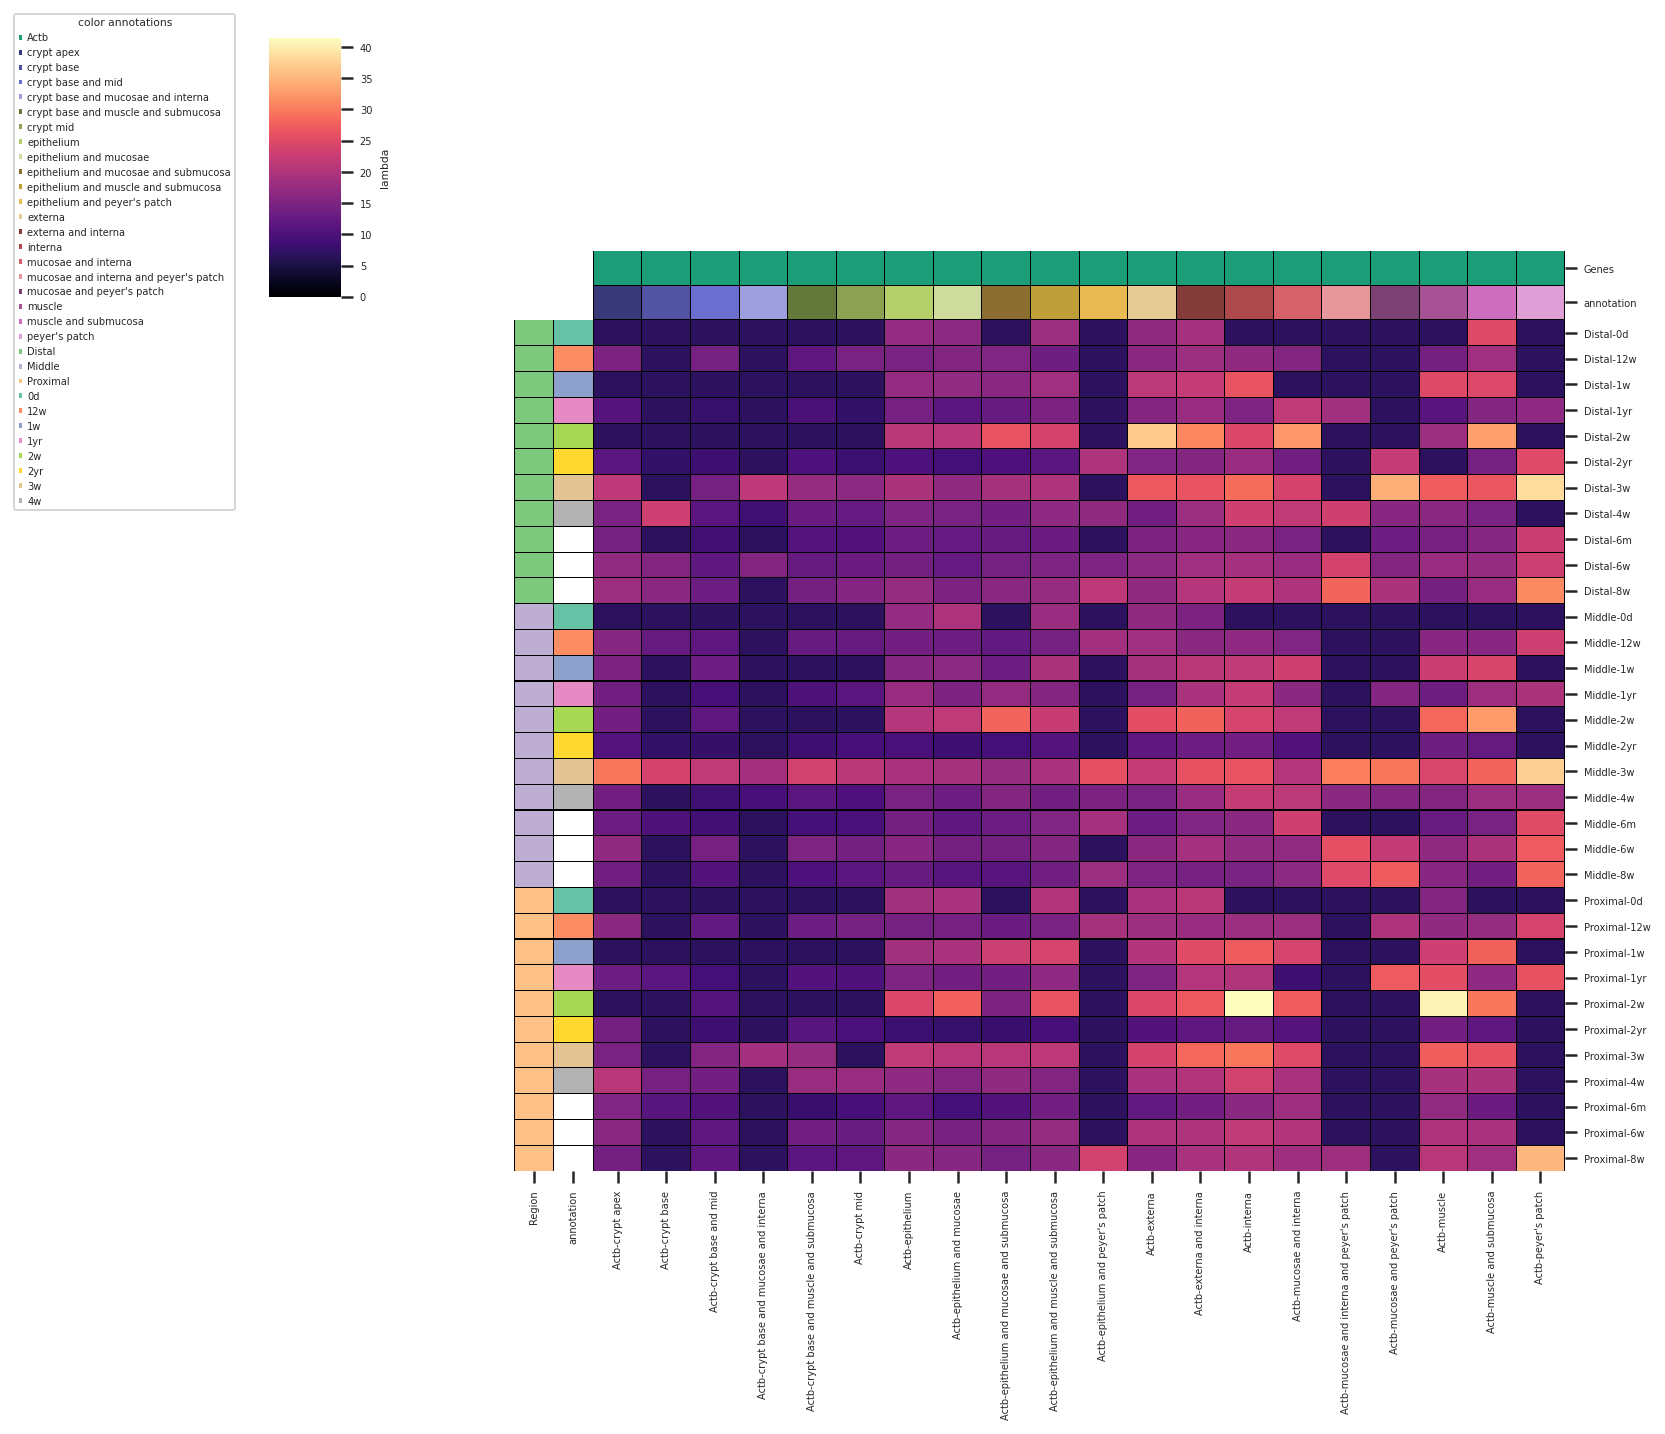

In [11]:
hm = labeled_clustermap(a, gene = ['Actb'], obs_cat = ['Region', 'annotation', 'Age'], use_common_regions = False)

Heatmaps that compare upregulated genes between regions: Proximal, Middle and Distal (on full dataset)

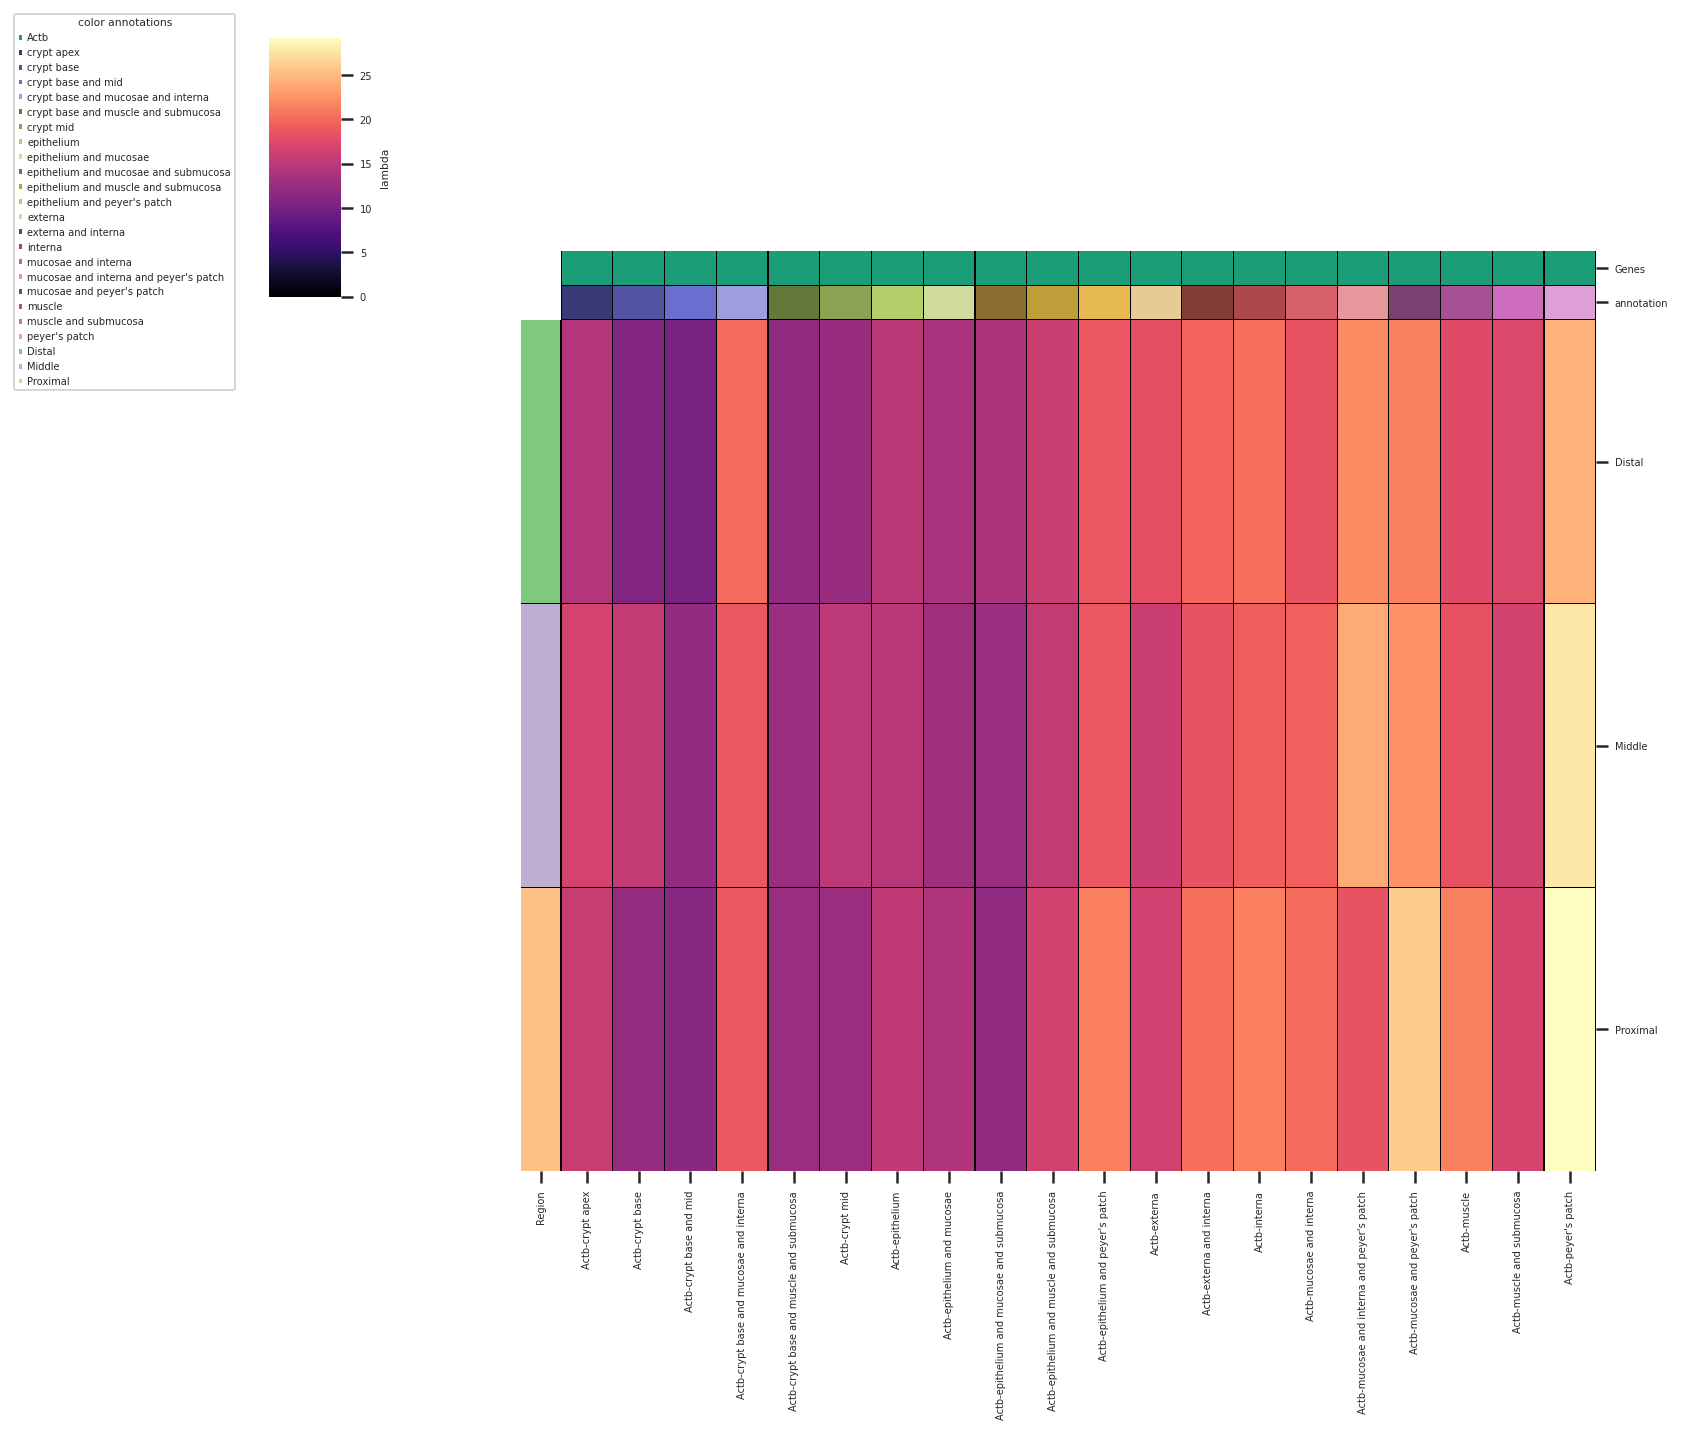

In [12]:
hm = labeled_clustermap(a, gene = ['Actb'], obs_cat = ['Region', 'annotation'], use_common_regions = False)

Heatmaps that compare upregulated genes between regions at fixed age: Proximal, Middle and Distal (using an intersect of common annotated areas)

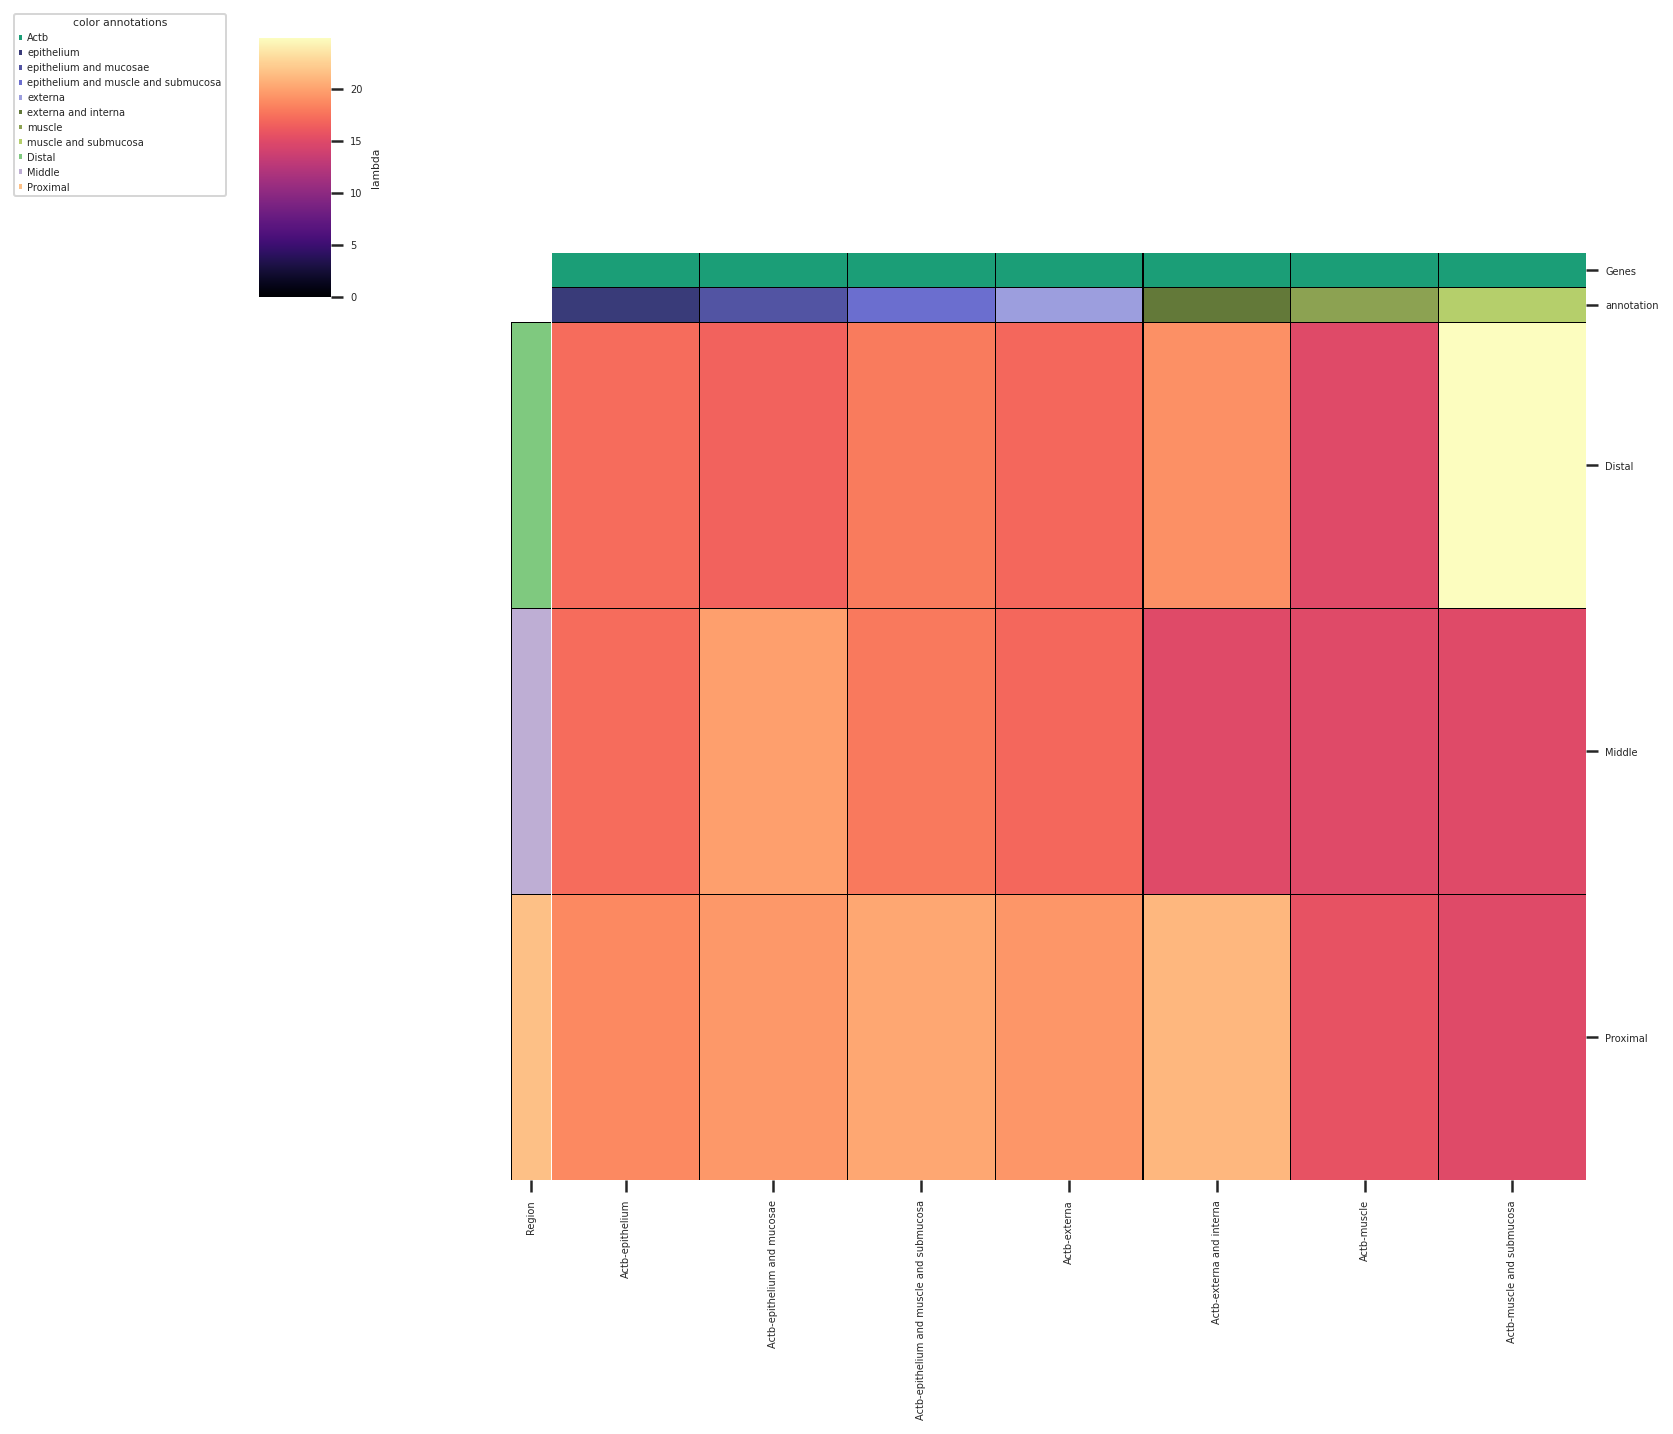

In [13]:
hm = labeled_clustermap(a[a.obs.Age == '0d'], gene = ['Actb'], obs_cat = ['Region', 'annotation'], use_common_regions = False)

Heatmaps that compare upregulated genes between ages at fixed regions: 0d, 12w and 2yr (using an intersect of common annotated areas)

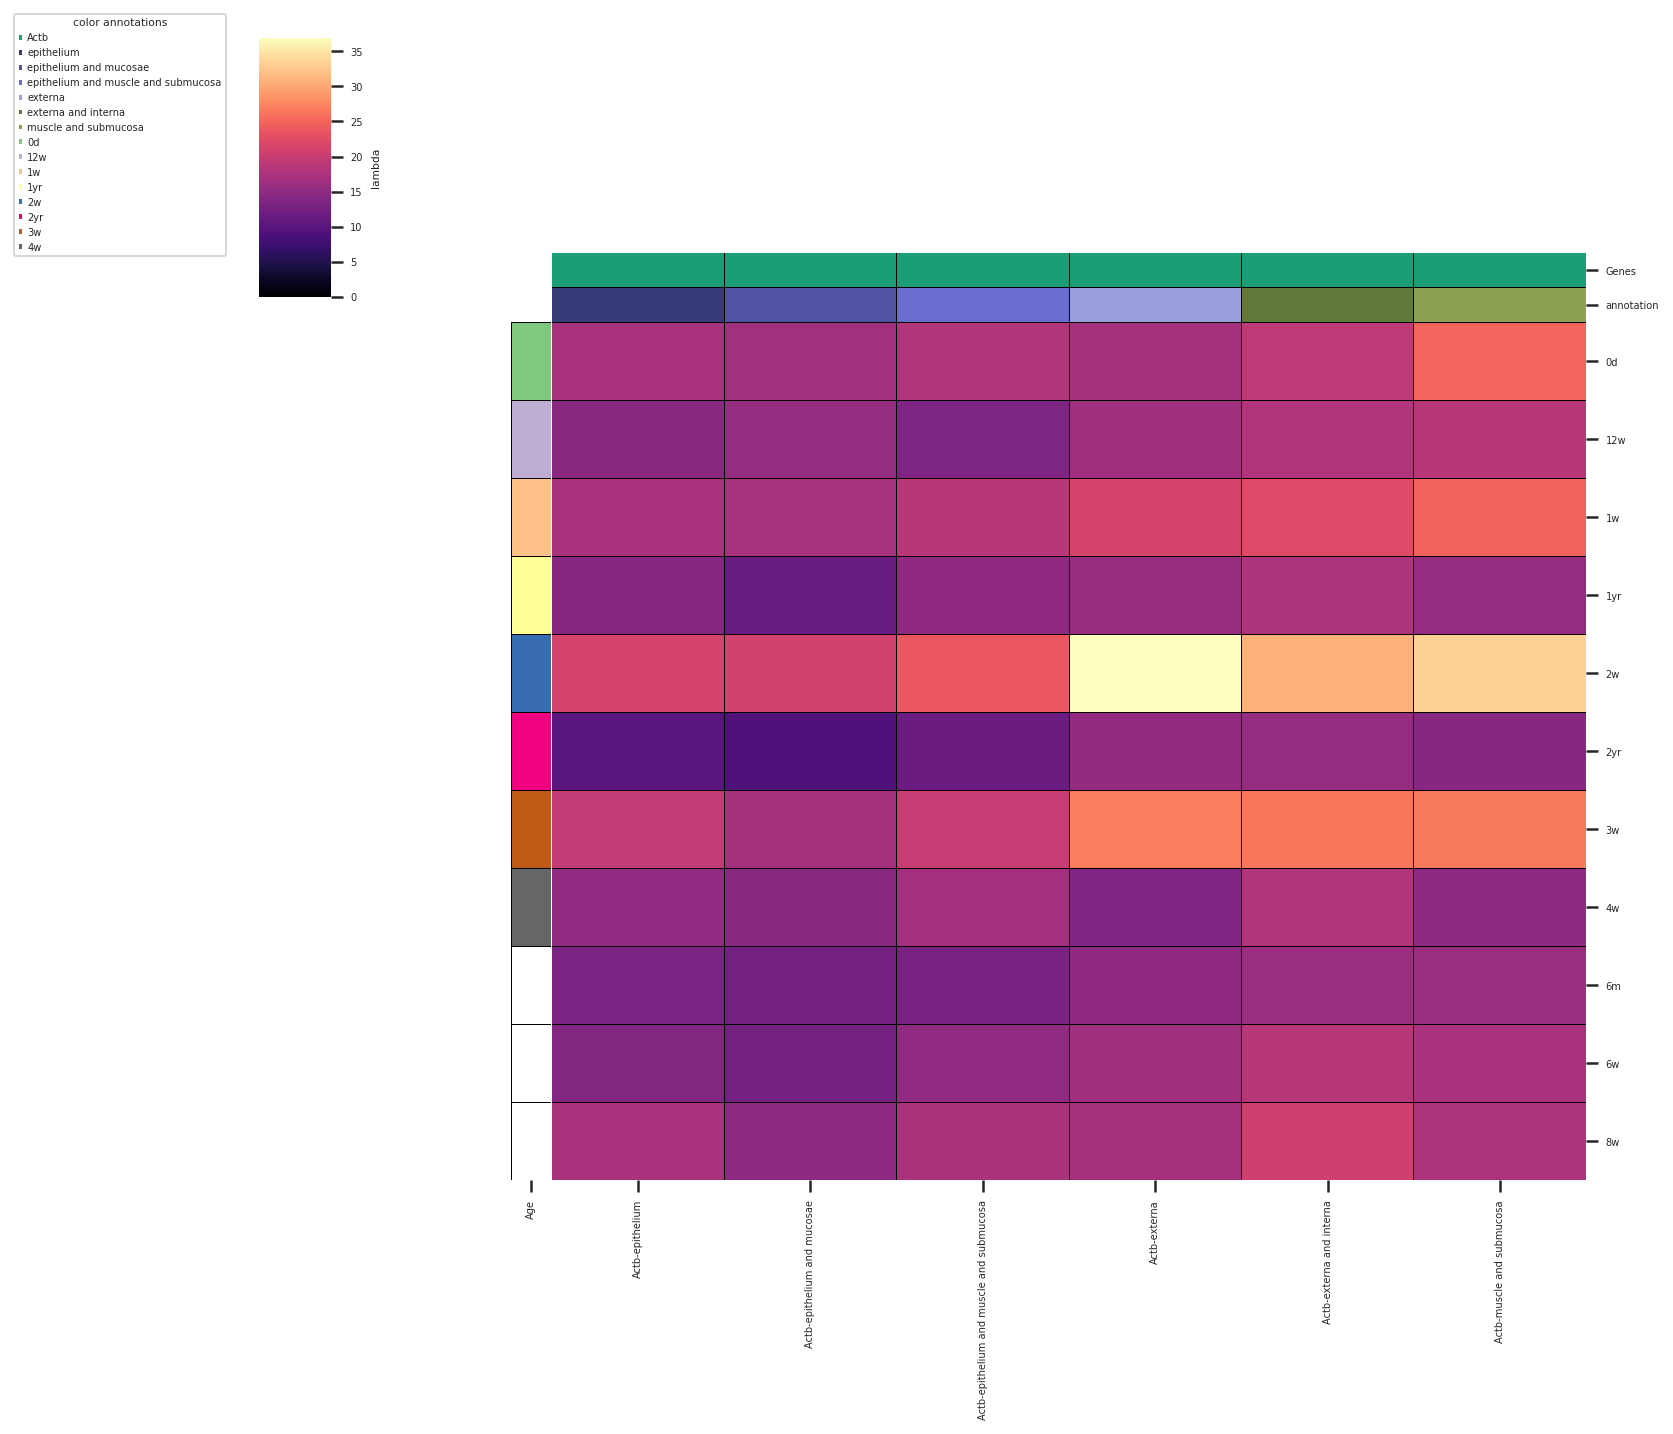

In [14]:
hm = labeled_clustermap(a[a.obs.Genotype == 'BL6WT.Distal'], gene = ['Actb'], obs_cat = ['Age', 'annotation'], use_common_regions = True)

Heatmaps that compare upregulated genes between timepoints: 0d, 12w and 2yrs (using an intersect of common annotated areas)

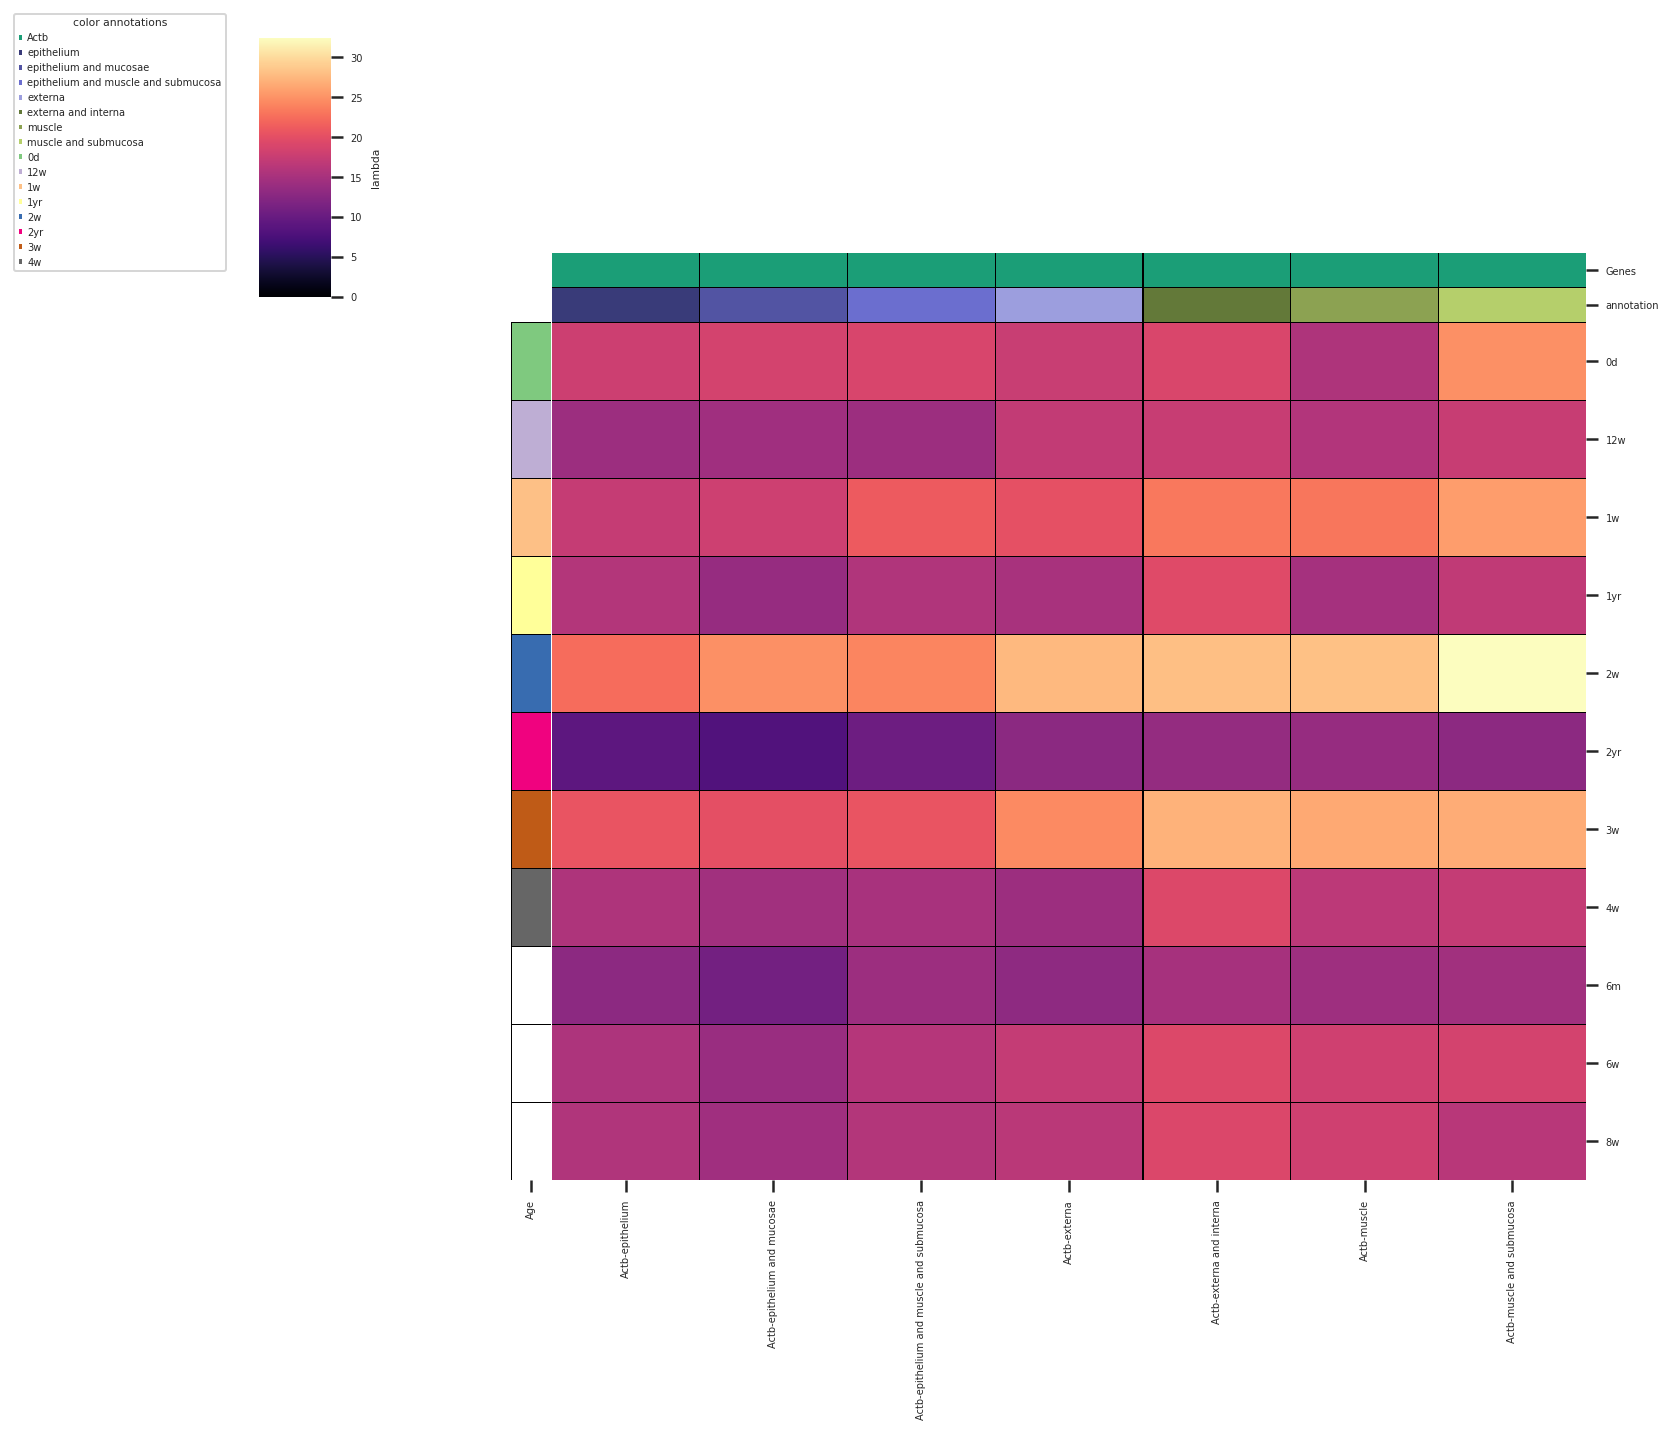

In [15]:
hm = labeled_clustermap(a, gene = ['Actb'], obs_cat = ['Age', 'annotation'], use_common_regions = True)

Heatmaps that compare upregulated genes between timepoints: 0d, 12w and 2yrs and regions: Proximal, Middle, Distal (using an intersect of common annotated areas)

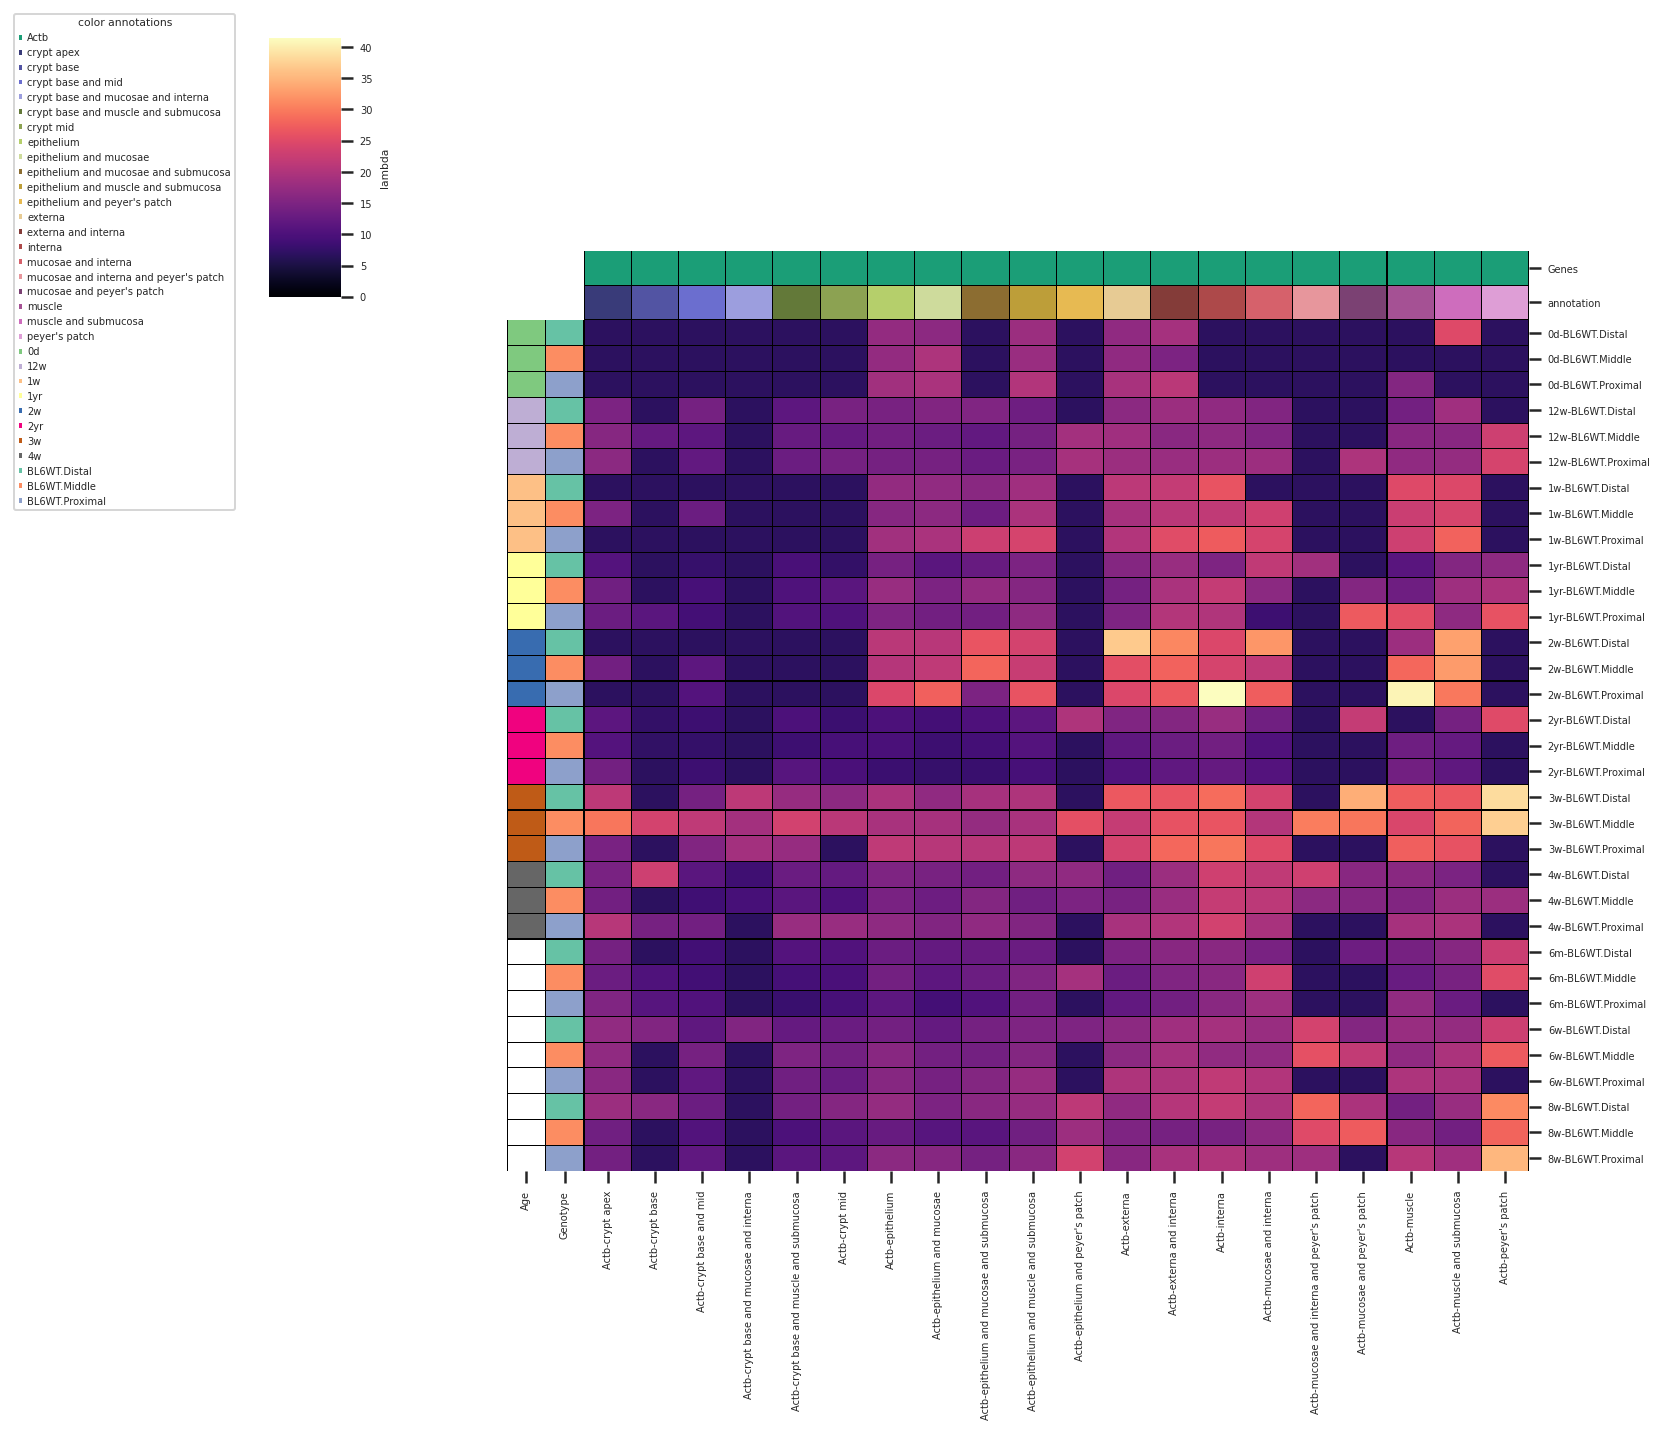

In [16]:
hm = labeled_clustermap(a, gene = ['Actb'], obs_cat = ['Age','Genotype','annotation'], use_common_regions = False)
# hm.savefig('Actb_heatmap_all.pdf',bbox_inches='tight',dpi=600)

## Transform splotch results

### Perform annotation analysis: one-vs-rest

Gives user information on genes specific for each annotated region irrespective of genotype or age

In [15]:
splotch2anndata_v3(ST_top_gene_dict, a, mode = 'annotation_analysis')

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable

annotation_analysis


### Perform regional analysis: one-vs-rest

Gives user information on genes specific for each colon region irrespective of age

In [16]:
'This might take a few minutes'
splotch2anndata_v3(ST_top_gene_dict, a, mode = 'genotype_analysis',conditions_order = ['Proximal_vs_Middle', 'Middle_vs_Distal', 'Distal_vs_Proximal']) 

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


genotype_analysis


### Perform temporal analysis: one-vs-rest

Gives user information on genes specific for each timepoint irrespective of genotype

In [17]:
'This might take a few minutes'
splotch2anndata_v3(ST_top_gene_dict, a, mode = 'temporal_analysis', conditions_order = ['1w_vs_0w', '2w_vs_1w', '3w_vs_2w', '4w_vs_3w', '6w_vs_4w', '8w_vs_6w',
                                                                                        '12w_vs_8w', '26w_vs_12w', '52w_vs_26w', '104w_vs_52w'])
#                    conditions_order = ['0d_vs_1w', '1w_vs_2w', '2w_vs_3w', '3w_vs_4w', '4w_vs_6w', '6w_vs_8w',
#                                '8w_vs_12w', '12w_vs_6m', '6m_vs_1yr', '1yr_vs_2yr'])
                   
#                    conditions_order = ['1w_vs_0d', '2w_vs_1w', '3w_vs_2w', '4w_vs_3w', '6w_vs_4w', '8w_vs_6w',
#                               '12w_vs_8w', '6m_vs_12w', '1yr_vs_6m', '2yr_vs_1yr'])
#                  conditions_order = ['0d_vs_1w', '1w_vs_2w', '2w_vs_3w', '3w_vs_4w', '4w_vs_6w', '6w_vs_8w',
#                               '8w_vs_12w', '12w_vs_6m', '6m_vs_1yr', '1yr_vs_2yr'])
#                                      conditions_order = ['0d', '1w', '2w', '3w', '4w', '6w',
#                                '8w', '12w', '6m', '1yr', '2yr'])

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable

temporal_analysis


categories: Distal, Middle, Proximal
var_group_labels: Distal_vs_Proximal, Middle_vs_Distal, Proximal_vs_Middle


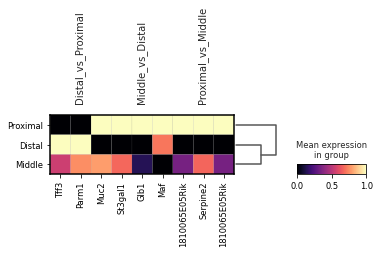

In [20]:
sc.pl.rank_genes_groups_matrixplot(a, cmap = 'magma', n_genes = 3,
                 groupby=['Region',], dendrogram=True, standard_scale='var',
                key = 'genotype_analysis')

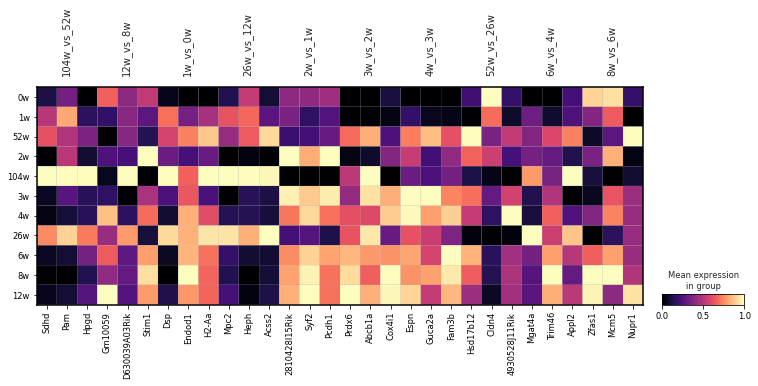

In [19]:
sc.pl.rank_genes_groups_matrixplot(a, cmap = 'magma', n_genes = 3,
                 groupby=['Age',], dendrogram=False, standard_scale='var',
                key = 'temporal_analysis')

... storing 'conditions' as categorical
         Falling back to preprocessing with `sc.pp.pca` and default params.


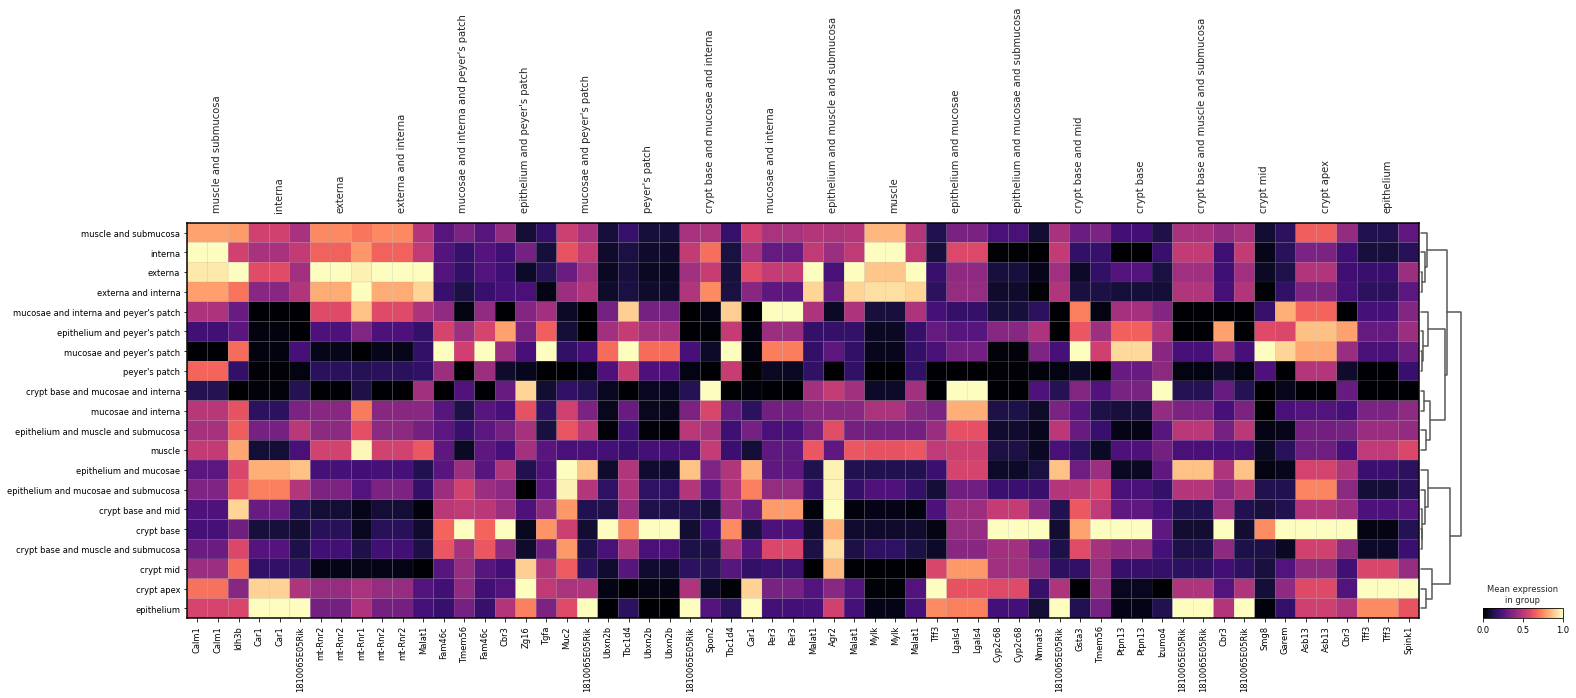

In [18]:
sc.pl.rank_genes_groups_matrixplot(a, cmap = 'magma', n_genes = 3,
                 groupby=['annotation'], dendrogram=True, standard_scale='var',
                key = 'annotation_analysis', )

In [21]:
# filter genes before plotting
filter_rank_genes_groups(a,  key = 'temporal_analysis', min_fold_change=0, min_scores = 0, min_pvals_change = 0.5, key_added = 'temporal_analysis_filtered')

In [22]:
# filter genes before plotting
filter_rank_genes_groups(a,  key = 'genotype_analysis', min_fold_change=0, min_scores = 0, min_pvals_change = 0.5, key_added = 'genotype_analysis_filtered')

In [23]:
# filter genes before plotting
filter_rank_genes_groups(a,  key = 'annotation_analysis', min_fold_change=0, min_scores = 0, min_pvals_change = 0.0, key_added = 'annotation_analysis_filtered')

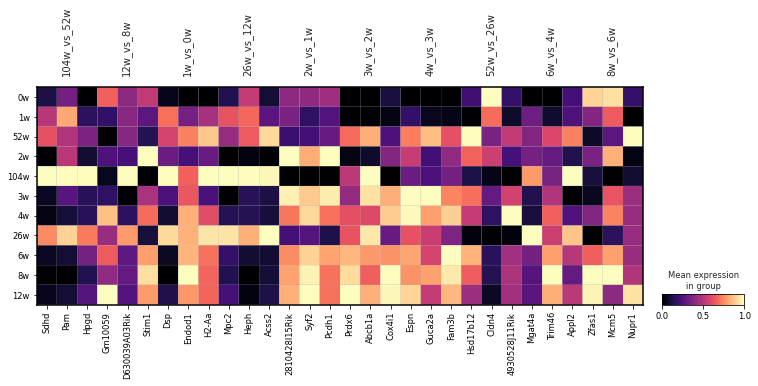

In [24]:
a_tmp = a[(a.obs.annotation == 'epithelium') & (a.obs.Region == 'Proximal') ]
sc.pl.rank_genes_groups_matrixplot(a, cmap = 'magma', n_genes = 3,
                 groupby=['Age', ], dendrogram=False, standard_scale='var',
                key = 'temporal_analysis_filtered', )#groups = [i for i in a_tmp.uns['temporal_analysis_filtered']['names'].dtype.names if "12w_" in i]

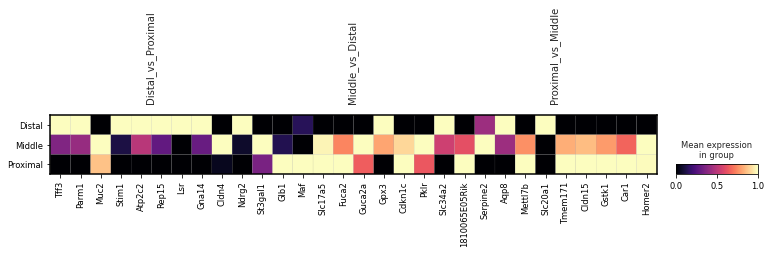

In [25]:
a_tmp = a[(a.obs.annotation == 'epithelium') & (a.obs.Age == '104w')]
sc.pl.rank_genes_groups_matrixplot(a_tmp, cmap = 'magma', n_genes = 10,
                 groupby=['Region',],dendrogram=False, standard_scale='var',
                key = 'genotype_analysis_filtered', )

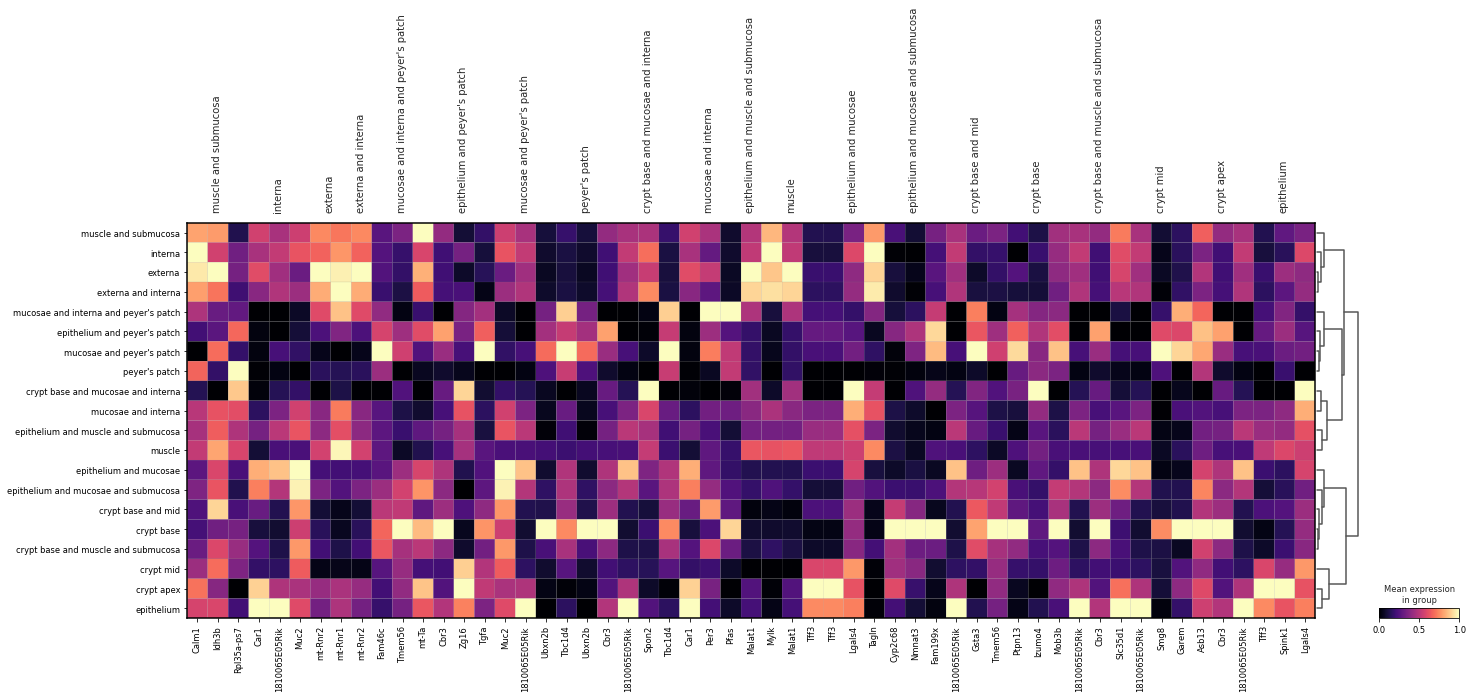

In [29]:
a_tmp = a[(a.obs.Region == 'Proximal') & (a.obs.Age == '12w') ]
#a_tmp = a_tmp[a_tmp.obs.annotation.isin(a_tmp.uns['annotation_analysis_filtered']['names'].dtype.names)]


#sc.tl.dendrogram(a_tmp, groupby=['annotation'])
sc.pl.rank_genes_groups_matrixplot(a, cmap = 'magma', n_genes = 3,
                 groupby=['annotation'], dendrogram=True, standard_scale='var',
                key = 'annotation_analysis_filtered', )

In [30]:
a.obs = a.obs.drop(['Genotype', 'batch', 'conditions', 'index'], axis=1)

In [31]:
a.uns.pop('annotation_analysis')
a.uns.pop('genotype_analysis')
a.uns.pop('temporal_analysis')

{'params': {'groupby': 'annotation',
  'reference': 'rest',
  'method': 'temporal_analysis',
  'use_raw': False,
  'layer': None},
 'names': rec.array([('Sdhd', 'Gm10059', 'Dsp', 'Mpc2', '2810428I15Rik', 'Prdx6', 'Espn', 'Hsd17b12', 'Mgat4a', 'Zfas1'),
            ('Pam', 'D630039A03Rik', 'Endod1', 'Heph', 'Syf2', 'Abcb1a', 'Guca2a', 'Cldn4', 'Trim46', 'Mcm5'),
            ('Hpgd', 'Stim1', 'H2-Aa', 'Acss2', 'Pcdh1', 'Cox4i1', 'Fam3b', '4930528J11Rik', 'Appl2', 'Nupr1'),
            ('Smpdl3a', 'Sptan1', 'Dsp', 'Il13ra1', 'Sdc1', 'Spint1', 'Hsd3b3', 'Krt19', 'Ddit4', 'Tmem208'),
            ('Ncl', 'Tpt1', 'Ldha', 'Khdrbs3', 'Elf3', 'Cox4i1', 'Ubc', 'Eif4a1', 'Rpl23', 'Cgref1'),
            ('mt-Tm', 'Gm4332', 'Guca2a', 'mt-Nd5', 'Tfeb', 'Crip1', 'Guk1', 'Rhob', 'Thbs4', 'Nabp2'),
            ('Ctnnd1', 'Herpud1', 'Ifi27l2b', 'Net1', 'Tjp3', 'Lgals4', 'Psmd8', 'Tceb2', 'Plcb3', 'P4hb'),
            ('Cd47', 'mt-Rnr2', 'Gls', 'Ier3ip1', 'Slc39a1', 'Prdx6', 'Ppfia3', 'Srrm1', 'Ahnak2', '

In [32]:
'Adds de genes pandas to uns'
a.write_h5ad(filename = '/home/sanjavickovic/data/st_data/anndata_colons_norm_all_degenes.h5ad')

In [4]:
a

AnnData object with n_obs × n_vars = 16783 × 8721
    obs: 'sample', 'x', 'y', 'centroids', 'cell_count', 'Age', 'Sex', 'Genotype', 'Specimen_ID', 'annotation'
    uns: 'annotation_analysis', 'annotation_analysis_filtered', 'cell_types_per_module', 'genotype_analysis', 'genotype_analysis_filtered', 'kegg_per_module', 'kegg_per_submodule', 'modules', 'submodules', 'temporal_analysis', 'temporal_analysis_filtered'